In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from adjustText import adjust_text
from sklearn.linear_model import LinearRegression

final_results_path = "results/final"

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
model_order = ["mlp", "cnn", "lstm"]
backend_order = ["jax", "jax-keras", "tf-keras", "torch-keras", "torch"]
precision_order = ["fp32", "fp16", "bf16", "mixed_fp16", "mixed_bf16"]
seed_order = ["42", "43", "44"]

Before all, a dataframe with all experiments' configuration and CSV paths is defined, for easier data manipulation.

In [4]:
# Dictionary to store the data
rows = []
error_rows = []

# Iterate through the seed folders
for seed in os.listdir(final_results_path):
    seed_path = os.path.join(final_results_path, seed)
    
    # Check that it is a directory
    if os.path.isdir(seed_path):

        # Iterate through the model folders inside each seed
        for folder in os.listdir(seed_path):
            folder_path = os.path.join(seed_path, folder)

            if not os.path.isdir(folder_path):
                continue

            # Extract info from folder name
            # Precision can contain _, so a workaround is needed
            timestamp, backend, model_type, model_complexity, right = folder.split("_", 4)
            precision, _ = right.rsplit("_", 1) # precision, seed

            experiment_info = {
                "timestamp": timestamp,
                "backend": backend,
                "model_type": model_type,
                "model_complexity": model_complexity,
                "precision": precision,
                "seed": seed,
            }

            if "error.txt" in os.listdir(folder_path):
                error_rows.append({
                    **experiment_info,
                    "path": os.path.join(folder_path, "error.txt")
                })
                continue

            # Add csv files' info
            for file in os.listdir(folder_path):
                if file.endswith(".csv"):
                    rows.append({
                        **experiment_info,
                        "filename": os.path.splitext(file)[0],  # Name without extension
                        "path": os.path.join(folder_path, file)
                    })


index_df = pd.DataFrame(rows)
error_df = pd.DataFrame(error_rows)

In [5]:
index_df.head()

,timestamp,backend,model_type,model_complexity,precision,seed,filename,path
0,20250724-142036,torch,mlp,simple,fp32,42,train_samples,results/final/42/20250724-142036_torch_mlp_sim...
1,20250724-142036,torch,mlp,simple,fp32,42,test_samples,results/final/42/20250724-142036_torch_mlp_sim...
2,20250724-142036,torch,mlp,simple,fp32,42,global_metrics,results/final/42/20250724-142036_torch_mlp_sim...
3,20250724-142036,torch,mlp,simple,fp32,42,train,results/final/42/20250724-142036_torch_mlp_sim...
4,20250724-142036,torch,mlp,simple,fp32,42,test,results/final/42/20250724-142036_torch_mlp_sim...


In [6]:
error_df.head()

,timestamp,backend,model_type,model_complexity,precision,seed,path
0,20250728-145122,torch-keras,lstm,simple,fp16,42,results/final/42/20250728-145122_torch-keras_l...
1,20250729-134409,jax,lstm,simple,bf16,42,results/final/42/20250729-134409_jax_lstm_simp...
2,20250726-152014,tf-keras,lstm,simple,bf16,42,results/final/42/20250726-152014_tf-keras_lstm...
3,20250728-145247,torch-keras,lstm,simple,bf16,42,results/final/42/20250728-145247_torch-keras_l...
4,20250729-134358,jax,lstm,simple,fp16,42,results/final/42/20250729-134358_jax_lstm_simp...


## Statistical analysis ##

In [7]:
experiment_config = ["backend", "model_type", "model_complexity", "precision", "seed"]
rows = []

for keys, subset_df in index_df.groupby(experiment_config):
    backend, model_type, model_complexity, precision, seed = keys

    row = {
        "backend": backend,
        "model_type": model_type,
        "model_complexity": model_complexity,
        "precision": precision,
        "seed": seed,
    }



    # --- Global metrics ---
    global_metrics_row = subset_df[subset_df["filename"] == "global_metrics"]
    global_metrics_df = pd.read_csv(global_metrics_row.iloc[0]["path"])
    global_metrics = global_metrics_df[["training_time", "testing_time"]].iloc[0]
    row.update(global_metrics.to_dict())



    # --- Train ---
    train_row = subset_df[subset_df["filename"] == "train"]
    train_df = pd.read_csv(train_row.iloc[0]["path"])

    # Metric can be accuracy or MAE
    try:
        metric_mean = train_df["accuracy"].mean()
        val_metric_mean = train_df["val_accuracy"].mean()
    except KeyError:
        metric_mean = train_df["mae"].mean()
        val_metric_mean = train_df["val_mae"].mean()

    row.update({
        "train_loss_mean": train_df["loss"].mean(),
        "train_metric_mean": metric_mean,
        "train_val_loss_mean": train_df["val_loss"].mean(),
        "train_val_metric_mean": val_metric_mean,
        "train_epoch_time_mean": train_df["epoch_time"].mean()
    })



    # --- Train samples ---
    train_samples_row = subset_df[subset_df["filename"] == "train_samples"]
    train_samples_df = pd.read_csv(train_samples_row.iloc[0]["path"])
    row.update({
        "train_gpu_utilization_mean": train_samples_df["gpu_2_utilization"].mean(),
        "train_gpu_memory_mean": train_samples_df["gpu_2_memory_used"].mean(),
        "train_gpu_power_mean": train_samples_df["gpu_2_power"].mean(),
    })



    # --- Test ---
    test_row = subset_df[subset_df["filename"] == "test"]
    test_df = pd.read_csv(test_row.iloc[0]["path"])

    try:
        metric_mean = train_df["accuracy"].mean()
    except KeyError:
        metric_mean = train_df["mae"].mean()

    row.update({
        "test_loss_mean": test_df["loss"].mean(),
        "test_metric_mean": metric_mean
    })



    # --- Test samples ---
    test_samples_row = subset_df[subset_df["filename"] == "test_samples"]
    test_samples_df = pd.read_csv(test_samples_row.iloc[0]["path"])
    row.update({
        "test_gpu_utilization_mean": test_samples_df["gpu_2_utilization"].mean(),
        "test_gpu_memory_mean": test_samples_df["gpu_2_memory_used"].mean(),
        "test_gpu_power_mean": test_samples_df["gpu_2_power"].mean(),
    })

    rows.append(row)

metrics_df = pd.DataFrame(rows)

In [8]:
metrics_df.head()

,backend,model_type,model_complexity,precision,seed,training_time,testing_time,train_loss_mean,train_metric_mean,train_val_loss_mean,train_val_metric_mean,train_epoch_time_mean,train_gpu_utilization_mean,train_gpu_memory_mean,train_gpu_power_mean,test_loss_mean,test_metric_mean,test_gpu_utilization_mean,test_gpu_memory_mean,test_gpu_power_mean
0,jax,cnn,simple,bf16,42,276.151817,2.418015,1.786719,0.358793,1.879609,0.401124,2.735608,9.556777,62087.106914,68.989505,1.859375,0.358793,NaN,NaN,NaN
1,jax,cnn,simple,bf16,43,258.165341,2.439186,1.730703,0.381797,1.834219,0.408910,2.553460,11.980392,62087.101225,68.816047,1.812500,0.381797,NaN,NaN,NaN
2,jax,cnn,simple,bf16,44,272.022249,2.433130,1.775703,0.363633,1.877031,0.387644,2.695274,9.888476,62087.105716,68.888335,1.875000,0.363633,NaN,NaN,NaN
3,jax,cnn,simple,fp16,42,305.029659,2.429303,NaN,0.100001,NaN,0.099964,3.016620,8.612583,62093.088162,67.226377,NaN,0.100001,NaN,NaN,NaN
4,jax,cnn,simple,fp16,43,283.138871,2.441872,NaN,0.099998,NaN,0.100075,2.803444,8.957143,62093.094643,67.078889,NaN,0.099998,NaN,NaN,NaN


In [9]:
metrics = metrics_df.columns[5:]
seed_variability = []

for metric in metrics:
    for (backend, model_type, model_complexity, precision), base_df in metrics_df.groupby(experiment_config[:-1]):
        values = base_df.sort_values("seed")[metric].values
        
        mean = np.mean(values)
        std = np.std(values)
        cv = std / mean if mean != 0 and pd.notna(mean) else 0
        consistent = cv < 0.1  # 10% maximum acceptable variation

        seed_variability.append({
            "backend": backend,
            "model_type": model_type,
            "model_complexity": model_complexity,
            "precision": precision,
            "metric": metric,
            "mean": mean,
            "std": std,
            "cv": cv,
            "consistent": consistent
        })

variability_df = pd.DataFrame(seed_variability)

In [10]:
variability_df.head()

,backend,model_type,model_complexity,precision,metric,mean,std,cv,consistent
0,jax,cnn,simple,bf16,training_time,268.779803,7.692569,0.028620,True
1,jax,cnn,simple,fp16,training_time,294.779322,8.990772,0.030500,True
2,jax,cnn,simple,fp32,training_time,284.455284,3.723989,0.013092,True
3,jax,cnn,simple,mixed_bf16,training_time,319.503012,3.276514,0.010255,True
4,jax,cnn,simple,mixed_fp16,training_time,349.468161,8.947256,0.025602,True


In [11]:
num_metrics = len(variability_df)
num_consistent = variability_df["consistent"].sum()
percent = (num_consistent / num_metrics) * 100
print(f"{percent:.2f}% of metrics are consistent between seeds ({num_consistent} out of {num_metrics})")

90.69% of metrics are consistent between seeds (925 out of 1020)


In [12]:
inconsistent_df = variability_df[~variability_df["consistent"]]
inconsistent_df.head()

,backend,model_type,model_complexity,precision,metric,mean,std,cv,consistent
17,jax-keras,cnn,simple,mixed_fp16,training_time,234.699164,24.417500,0.104037,False
27,tf-keras,cnn,simple,fp16,training_time,141.424864,15.303753,0.108211,False
30,tf-keras,cnn,simple,mixed_fp16,training_time,163.126355,17.509885,0.107339,False
74,jax,lstm,simple,mixed_bf16,testing_time,2.802004,0.472777,0.168728,False
75,jax,lstm,simple,mixed_fp16,testing_time,2.776334,0.479126,0.172575,False


In [13]:
(
    inconsistent_df
    .groupby(["backend", "model_type", "model_complexity"])
    .size()
    .reset_index(name="n_inconsistent")
    .sort_values("n_inconsistent", ascending=False)
)

,backend,model_type,model_complexity,n_inconsistent
7,tf-keras,lstm,simple,13
13,torch-keras,lstm,simple,12
5,jax-keras,mlp,simple,11
8,tf-keras,mlp,simple,8
12,torch-keras,cnn,simple,8
6,tf-keras,cnn,simple,8
10,torch,lstm,simple,7
2,jax,mlp,simple,6
9,torch,cnn,simple,5
3,jax-keras,cnn,simple,5


In [14]:
(
    inconsistent_df
    .groupby(["backend"])
    .size()
    .reset_index(name="n_inconsistent")
    .sort_values("n_inconsistent", ascending=False)
)

,backend,n_inconsistent
2,tf-keras,29
4,torch-keras,22
1,jax-keras,21
3,torch,13
0,jax,10


In [15]:
(
    variability_df
    .groupby(["backend"])["consistent"]
    .mean()
    .reset_index(name="%_consistent")
    .sort_values("%_consistent")
)

,backend,%_consistent
2,tf-keras,0.861905
4,torch-keras,0.887179
1,jax-keras,0.892308
3,torch,0.942222
0,jax,0.948718


In [16]:
(
    variability_df
    .groupby(["model_type"])["consistent"]
    .mean()
    .reset_index(name="%_consistent")
    .sort_values("%_consistent")
    .head(20)
)

,model_type,%_consistent
1,lstm,0.855556
0,cnn,0.925333
2,mlp,0.925333


In [17]:
(
    variability_df
    .groupby(["precision"])["consistent"]
    .mean()
    .reset_index(name="%_consistent")
    .sort_values("%_consistent")
    .head(20)
)

,precision,%_consistent
4,mixed_fp16,0.893333
3,mixed_bf16,0.897778
1,fp16,0.905556
0,bf16,0.909091
2,fp32,0.928889


In [18]:
summary_df = variability_df.copy()

# column with format "mean ± std"
summary_df["value"] = summary_df.apply(
    lambda row: f"{row['mean']:.3f} ± {row['std']:.3f}", axis=1
)

pivot_table = summary_df.pivot_table(
    index=["model_type", "backend"],
    columns="metric",
    values="value",
    aggfunc="first"
).reset_index()

#pivot_table.to_latex("summary_table.tex", index=False, escape=False)

# Results analysis

In [19]:
orders = {
    "model_type": ["mlp", "cnn", "lstm"],
    "backend": ["jax", "jax-keras", "tf-keras", "torch-keras", "torch"],
    "precision": ["fp32", "fp16", "bf16", "mixed_fp16", "mixed_bf16"],
    "seed": ["42", "43", "44"],
}

labels = {
    "model_type": {m: m.upper() for m in orders["model_type"]},
    "backend": {
        "jax": "JAX",
        "jax-keras": "JAX-Keras",
        "tf-keras": "TF-Keras",
        "torch-keras": "Torch-Keras",
        "torch": "Torch",
    },
    "precision": {
        "fp32": "FP32",
        "fp16": "FP16",
        "bf16": "BF16",
        "mixed_fp16": "Mixed (FP16)",
        "mixed_bf16": "Mixed (BF16)",
    },
    "seed": {s: s for s in orders["seed"]},
}

titles = {
    "model_type": "Model",
    "backend": "Framework",
    "precision": "Precision",
    "seed": "Seed",
}

def add_labels(df, sufix="", *, orders=orders, labels=labels):
    df = df.copy()

    for col, order in orders.items():

        if col not in df.columns:
            continue

        label_dict = labels[col]

        df[f"{col}{sufix}"] = pd.Categorical(
            df[col].map(label_dict),
            categories=[label_dict[o] for o in order],
            ordered=True,
        )

    return df


In [20]:
def add_title(plot, title, adjust=0.85, fontsize="large"):
    plot.figure.suptitle(title, fontsize=fontsize)
    plot.figure.subplots_adjust(top=adjust)

## Execution time

In [21]:
time_df = metrics_df[experiment_config + ["training_time", "testing_time"]].copy()
time_df.head()

,backend,model_type,model_complexity,precision,seed,training_time,testing_time
0,jax,cnn,simple,bf16,42,276.151817,2.418015
1,jax,cnn,simple,bf16,43,258.165341,2.439186
2,jax,cnn,simple,bf16,44,272.022249,2.433130
3,jax,cnn,simple,fp16,42,305.029659,2.429303
4,jax,cnn,simple,fp16,43,283.138871,2.441872


In [22]:
def format_legend_title(plot, feature="precision", *, titles=titles):
    title = titles[feature]
    plot._legend.set_title(fr"$\bf{{ {title} }}$")

In [23]:
def save_svg(plot, name):
    img_path = f"img/{name}.svg"

    try:
        plot.savefig(img_path, format="svg")
    except:
        plt.savefig(img_path, format="svg")

### Training time

In [24]:
add_labels(time_df).head()

,backend,model_type,model_complexity,precision,seed,training_time,testing_time
0,JAX,CNN,simple,BF16,42,276.151817,2.418015
1,JAX,CNN,simple,BF16,43,258.165341,2.439186
2,JAX,CNN,simple,BF16,44,272.022249,2.433130
3,JAX,CNN,simple,FP16,42,305.029659,2.429303
4,JAX,CNN,simple,FP16,43,283.138871,2.441872


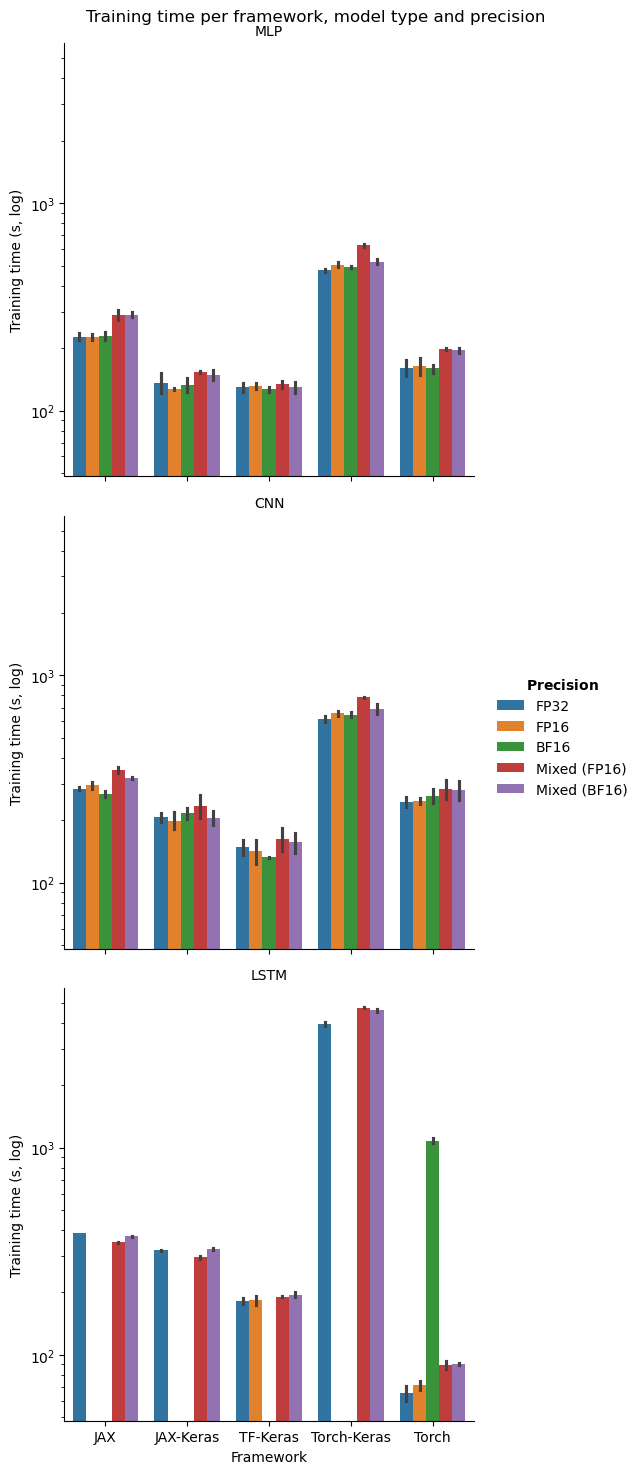

In [25]:
plot = sns.catplot(
    data=add_labels(time_df),
    x="backend",
    y="training_time",
    hue="precision",
    row="model_type",
    kind="bar",
    errorbar="sd"
)

# Title
add_title(plot, "Training time per framework, model type and precision", adjust=0.95)

plot.set(yscale="log")

plot.set_axis_labels(titles["backend"], "Training time (s, log)")

format_legend_title(plot)

plot.set_titles("{row_name}")

plot.tight_layout()

save_svg(plot, "training_time")

In [26]:
time_df.head()

,backend,model_type,model_complexity,precision,seed,training_time,testing_time
0,jax,cnn,simple,bf16,42,276.151817,2.418015
1,jax,cnn,simple,bf16,43,258.165341,2.439186
2,jax,cnn,simple,bf16,44,272.022249,2.433130
3,jax,cnn,simple,fp16,42,305.029659,2.429303
4,jax,cnn,simple,fp16,43,283.138871,2.441872


In [194]:
base_df = time_df.query("model_type=='lstm'").copy()
base_df = (
    base_df.groupby(experiment_config[:-2])["training_time"]
    .median()
    .reset_index()
)
ref = base_df["training_time"].min()
base_df["training_time_comp"] = 1 - (base_df["training_time"] / ref)
base_df = base_df.sort_values(by="training_time", ascending=True)
base_df.head()

,backend,model_type,training_time,training_time_comp
14,torch,lstm,89.114753,0.000000
8,tf-keras,lstm,189.304270,-1.124275
5,jax-keras,lstm,319.006382,-2.579726
2,jax,lstm,373.125164,-3.187019
11,torch-keras,lstm,4628.777854,-50.941768


### Testing time

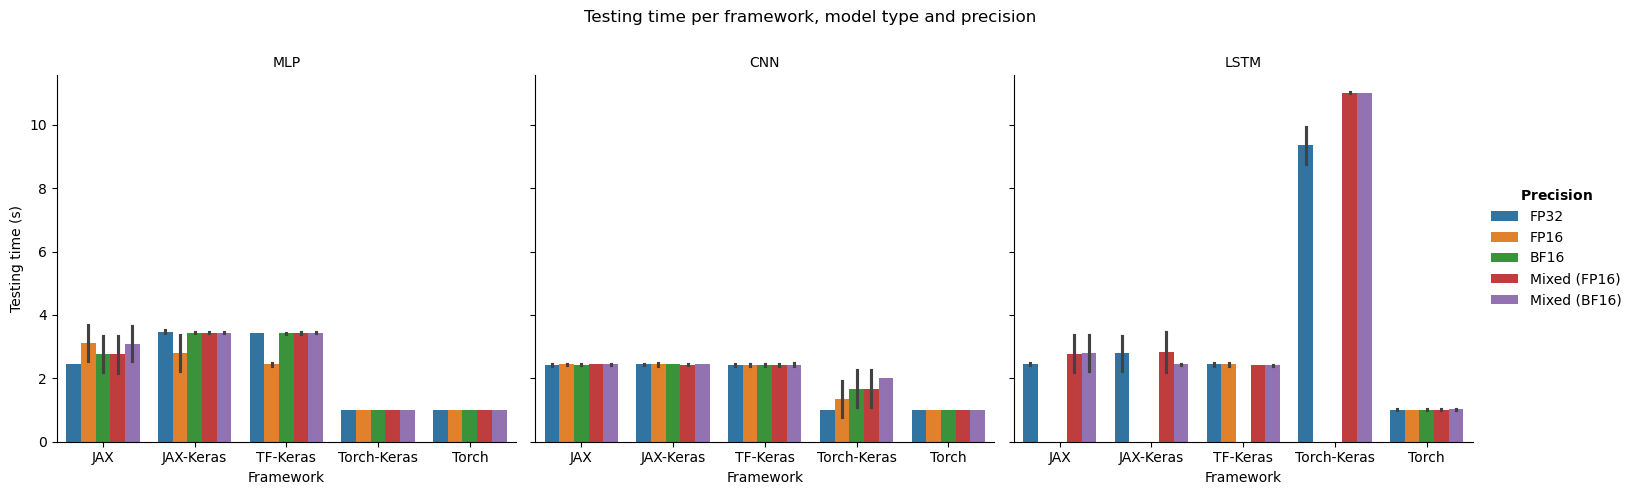

In [28]:
plot = sns.catplot(
    data=add_labels(time_df),
    x="backend",
    y="testing_time",
    hue="precision",
    col="model_type",
    kind="bar",
    errorbar="sd"
)

# Title
add_title(plot, "Testing time per framework, model type and precision")

plot.set_axis_labels(titles["backend"], "Testing time (s)")

format_legend_title(plot)

plot.set_titles("{col_name}")

save_svg(plot, "testing_time")

In [29]:
base_df = time_df.query("model_type=='lstm'").copy()
base_df = (
    base_df.groupby(experiment_config[:-2])["testing_time"]
    .median()
    .reset_index()
)
ref = base_df["testing_time"].min()
base_df["testing_time_comp"] = (1 - (base_df["testing_time"] / ref))
base_df = base_df.sort_values(by="testing_time", ascending=True)
base_df.head()

,backend,model_type,model_complexity,testing_time,testing_time_comp
3,torch,lstm,simple,1.011158,0.000000
2,tf-keras,lstm,simple,2.418058,-1.391376
1,jax-keras,lstm,simple,2.462740,-1.435565
0,jax,lstm,simple,2.465208,-1.438006
4,torch-keras,lstm,simple,11.016919,-9.895354


## GPU metrics

In [30]:
def exp_config_category(df):
    # Convert experiment config columns to categorical, for better performance
    orders = [backend_order, model_order, precision_order, seed_order]

    for col, order in zip(experiment_config, orders):
        df[col] = pd.Categorical(
            df[col],
            categories=order,
            ordered=True
        )
    
    return df

In [31]:
experiment_config = ["backend", "model_type", "precision", "seed"] # Remove model_complexity (is always "simple")
df_list = []

for keys, subset_df in index_df[index_df["filename"] == "train_samples"].groupby(experiment_config):
    backend, model_type, precision, seed = keys

    base_df = pd.read_csv(subset_df.iloc[0]["path"])

    base_df["backend"] = backend
    base_df["model_type"] = model_type
    base_df["precision"] = precision
    base_df["seed"] = seed

    df_list.append(base_df)

train_samples_df = pd.concat(df_list, ignore_index=True)

train_samples_df = exp_config_category(train_samples_df)

train_samples_df = train_samples_df.sort_values(by=experiment_config).reset_index(drop=True)

train_samples_df.head()

,timestamp,gpu_2_utilization,gpu_2_memory_used,gpu_2_power,backend,model_type,precision,seed
0,2.190392,0,62065.1875,64.923,jax,mlp,fp32,42
1,3.191456,0,62075.1875,63.950,jax,mlp,fp32,42
2,4.192263,9,62075.1875,65.681,jax,mlp,fp32,42
3,5.193223,0,62075.1875,64.644,jax,mlp,fp32,42
4,6.194193,0,62075.1875,64.436,jax,mlp,fp32,42


### GPU utilization

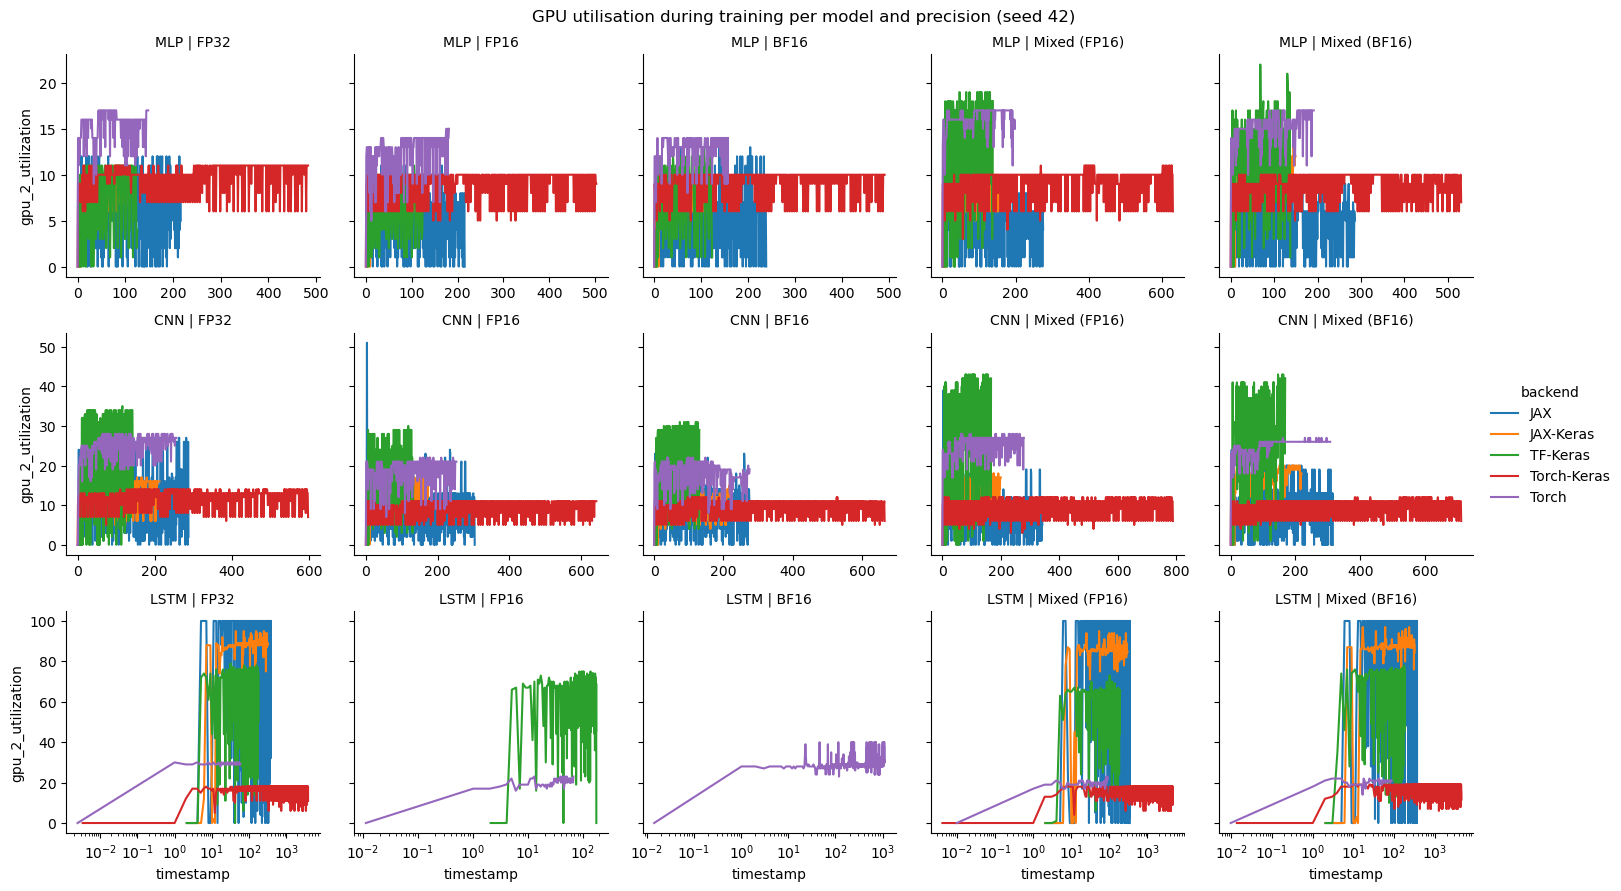

In [32]:
base_df = add_labels(train_samples_df.query("seed == '42'"))

plot = sns.relplot(
    data=base_df,
    x="timestamp",
    y="gpu_2_utilization",
    kind="line",
    hue="backend",
    col="precision",
    row="model_type",
    facet_kws={"sharey": "row", "sharex": False},
    height=3
)

add_title(plot, "GPU utilisation during training per model and precision (seed 42)", adjust=0.93)

plot.set_titles(row_template="{row_name}", col_template="{col_name}")

for ax in plot.axes[-1]:
    ax.set_xscale("log")

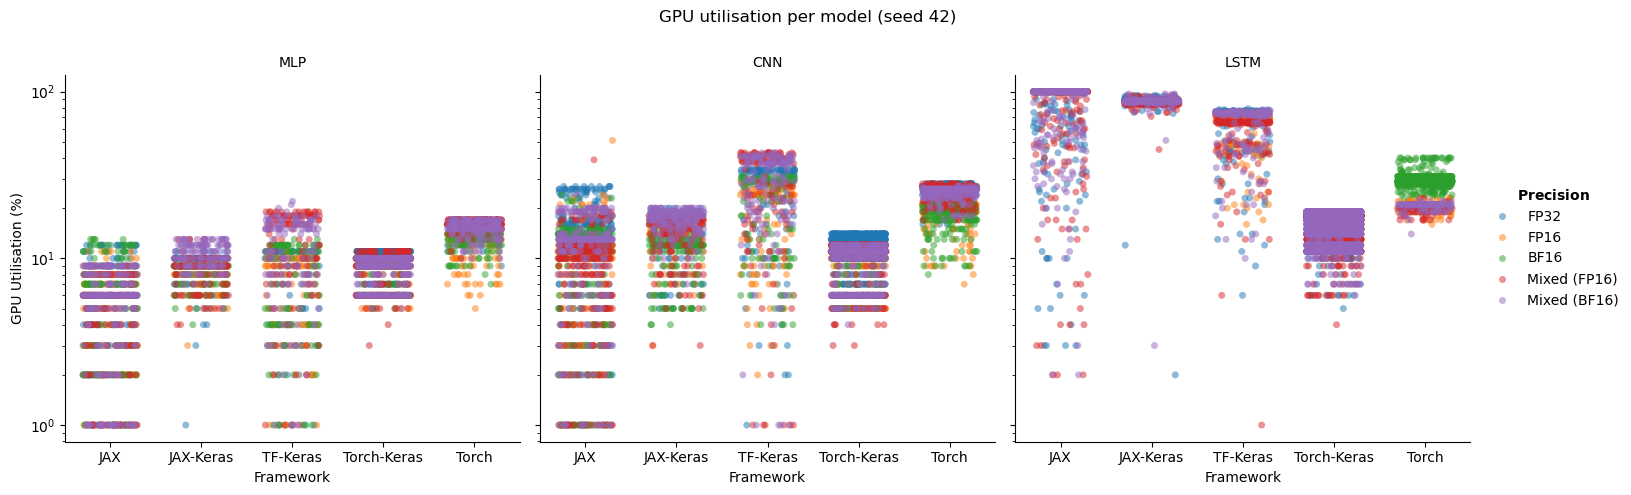

In [33]:
base_df = add_labels(train_samples_df.query("seed == '42'"))

plot = sns.catplot(
    data=base_df,
    x="backend",
    y="gpu_2_utilization",
    hue="precision",
    col="model_type",
    kind="strip",
    jitter="0.3",
    alpha=0.5,
)

add_title(plot, "GPU utilisation per model (seed 42)")

format_legend_title(plot)

plot.set_titles(col_template="{col_name}")
plot.set_axis_labels(titles["backend"], "GPU Utilisation (%)")

plot.set(yscale="log")

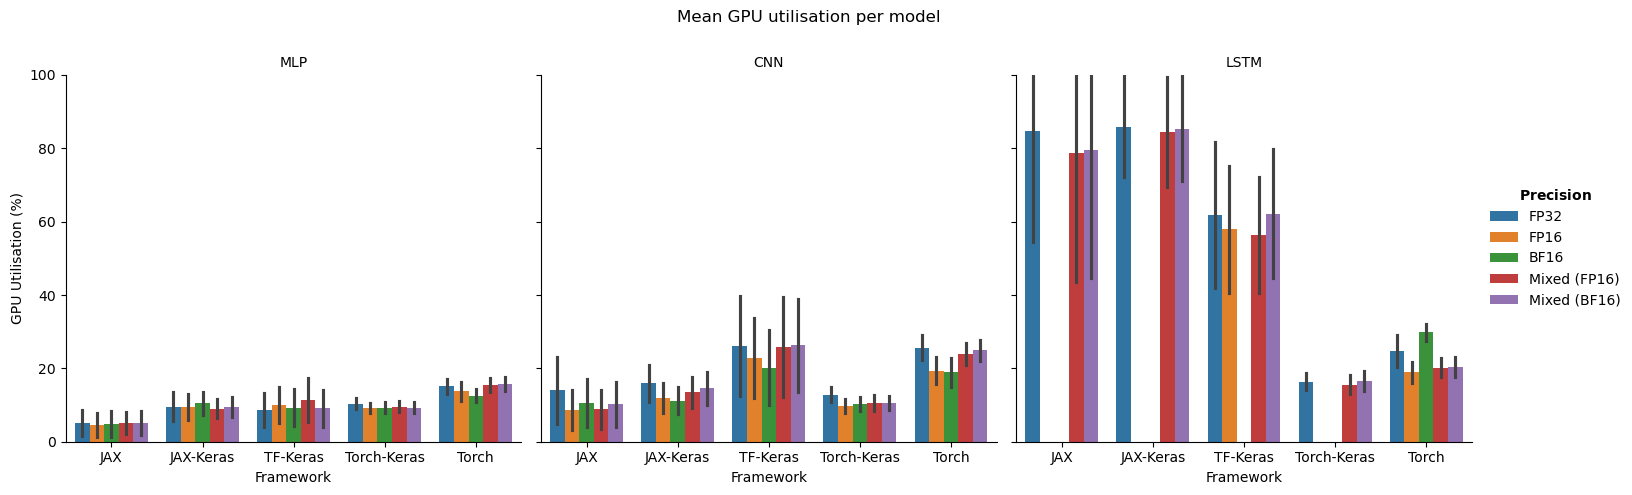

In [34]:
plot = sns.catplot(
    data=add_labels(train_samples_df),
    x="backend",
    y="gpu_2_utilization",
    hue="precision",
    col="model_type",
    kind="bar",
    errorbar="sd"
)

add_title(plot, "Mean GPU utilisation per model")
format_legend_title(plot)

plot.set_titles(col_template="{col_name}")
plot.set_axis_labels(titles["backend"], "GPU Utilisation (%)")

plot.set(ylim=(0, 100))

save_svg(plot, "utilisation_bars")

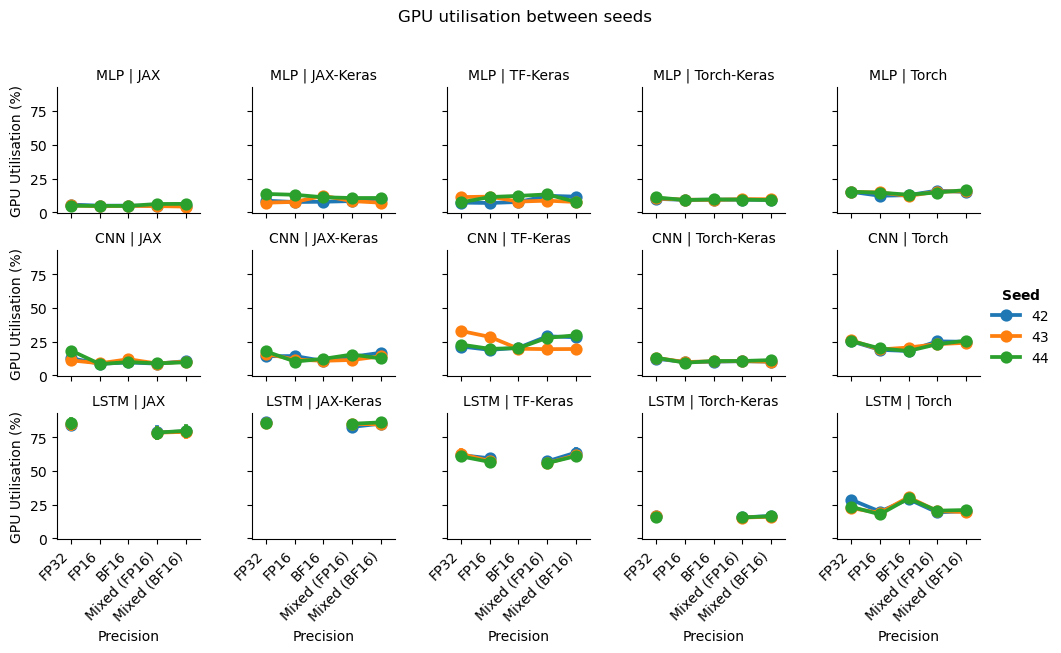

In [35]:
plot = sns.catplot(
    data=add_labels(train_samples_df),
    x="precision",
    y="gpu_2_utilization",
    hue="seed",
    row="model_type",
    col="backend",
    kind="point",
    height=2
)

add_title(plot, "GPU utilisation between seeds")
format_legend_title(plot, "seed")

plot.set_titles(row_template="{row_name}", col_template="{col_name}")
plot.set_axis_labels(titles["precision"], "GPU Utilisation (%)")

for ax in plot.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")

save_svg(plot, "utilisation_seeds")




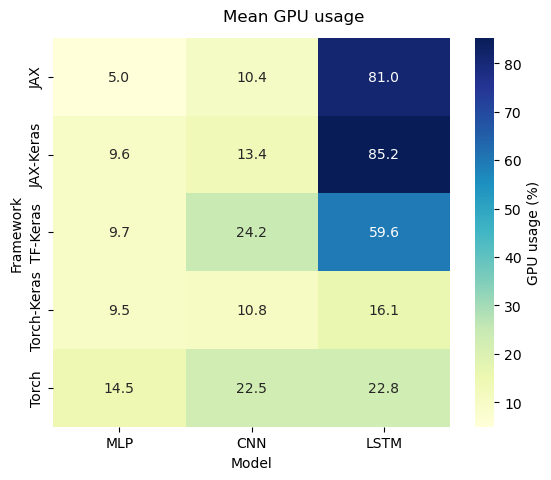

In [36]:
df_avg = train_samples_df.groupby(["backend","model_type","precision"])["gpu_2_utilization"].mean().reset_index()

df_pivot = df_avg.pivot_table(
    index="backend", columns="model_type", values="gpu_2_utilization"
)

# Add labels
df_pivot.index   = df_pivot.index.map(labels["backend"])
df_pivot.columns = df_pivot.columns.map(labels["model_type"])

plot = sns.heatmap(
    df_pivot,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    cbar_kws={"label": "GPU usage (%)"}
)

add_title(plot, "Mean GPU usage", adjust=0.92)
plot.set_xlabel(titles["model_type"])
plot.set_ylabel(titles["backend"])

save_svg(plot, "usage_heatmap")

### GPU memory

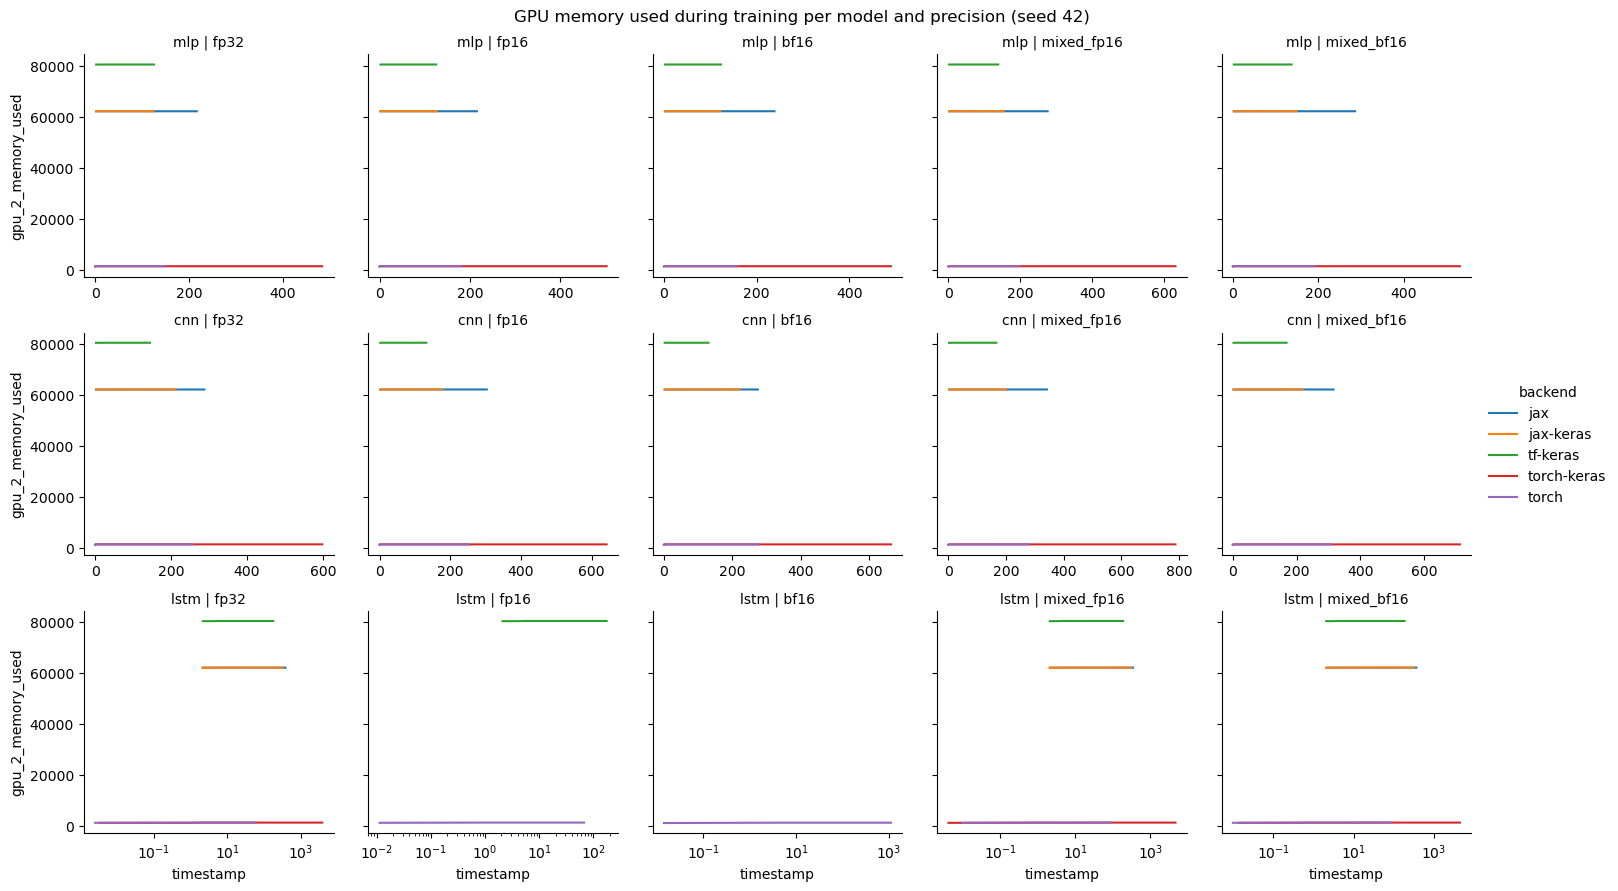

In [37]:
plot = sns.relplot(
    data=train_samples_df.query("seed == '42'"),
    x="timestamp",
    y="gpu_2_memory_used",
    kind="line",
    hue="backend",
    col="precision",
    row="model_type",
    facet_kws={"sharey": "row", "sharex": False},
    hue_order=backend_order,
    col_order=precision_order,
    row_order=model_order,
    height=3
)

add_title(plot, "GPU memory used during training per model and precision (seed 42)", adjust=0.93)

plot.set_titles(row_template="{row_name}", col_template="{col_name}")

for ax in plot.axes[-1]:
    ax.set_xscale("log")

In [38]:
memory_df = train_samples_df.groupby(["backend","model_type","precision"])["gpu_2_memory_used"].max().reset_index()
memory_df["max_memory"] = memory_df["gpu_2_memory_used"] / 1024  # Convert to GB
memory_df = memory_df.drop("gpu_2_memory_used", axis=1)
memory_df.head()

,backend,model_type,precision,max_memory
0,jax,mlp,fp32,60.622253
1,jax,mlp,fp16,60.630066
2,jax,mlp,bf16,60.630066
3,jax,mlp,mixed_fp16,60.630066
4,jax,mlp,mixed_bf16,60.630066


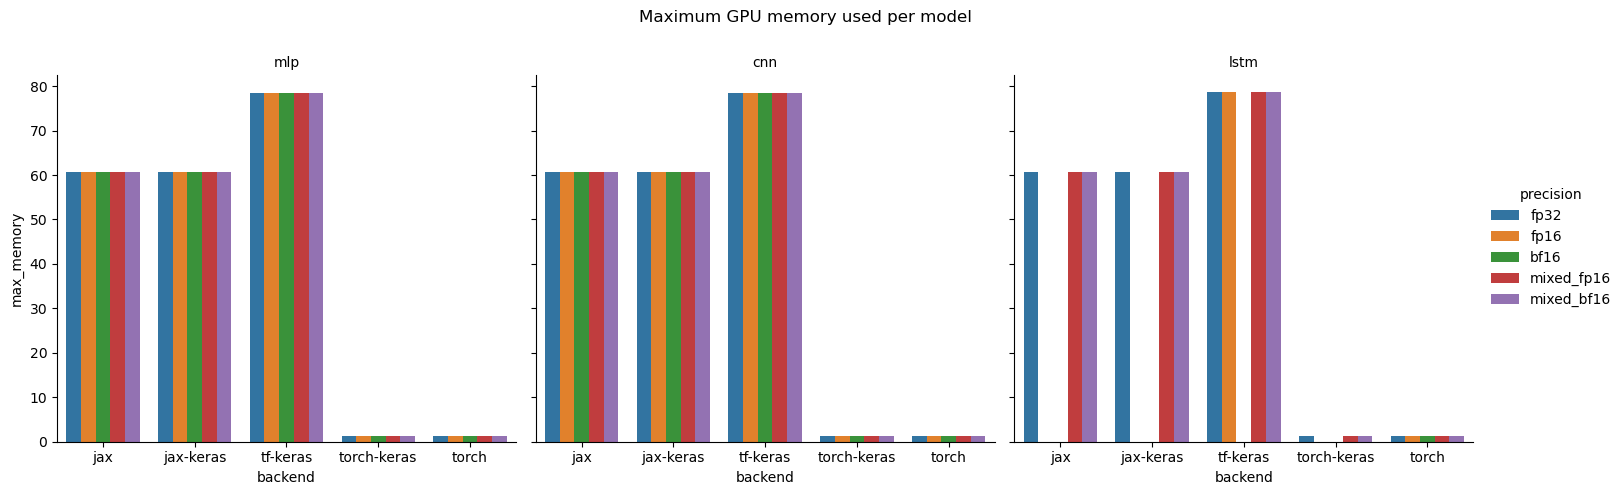

In [39]:
plot = sns.catplot(
    data=memory_df,
    x="backend",
    y="max_memory",
    hue="precision",
    col="model_type",
    kind="bar",
    errorbar="sd"
)

add_title(plot, "Maximum GPU memory used per model")

plot.set_titles(col_template="{col_name}")

In [40]:
memory_df = memory_df.groupby(["backend"])["max_memory"].max().sort_values(ascending=False).reset_index()
memory_df.head()

,backend,max_memory
0,tf-keras,78.569519
1,jax-keras,60.706238
2,jax,60.704285
3,torch,1.341003
4,torch-keras,1.329285


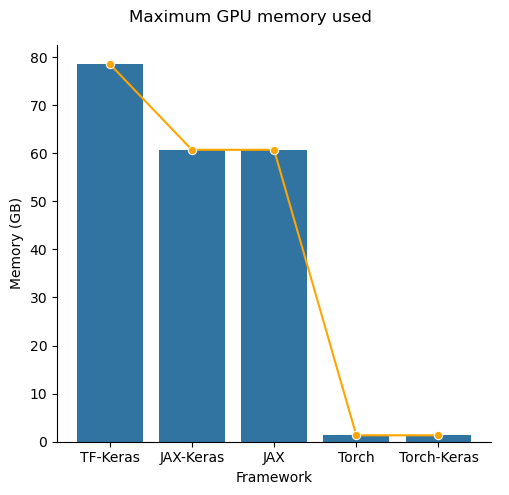

In [41]:
base_df = add_labels(memory_df)

plot = sns.catplot(
    data=base_df,
    x="backend",
    y="max_memory",
    kind="bar",
    errorbar="sd",
    order=base_df["backend"]
)

sns.lineplot(
    x=base_df["backend"],
    y=base_df["max_memory"],
    ax=plot.ax,
    marker="o",
    color="orange"
)

add_title(plot, "Maximum GPU memory used")
plot.set_axis_labels(titles["backend"], "Memory (GB)")

plt.tight_layout()

save_svg(plot, "memory_bars")

### GPU Power

In [42]:
energy_df = train_samples_df[experiment_config + ["timestamp", "gpu_2_power"]]

energy_df = energy_df.sort_values(by=experiment_config + ["timestamp"]).reset_index(drop=True)
energy_df.head()

,backend,model_type,precision,seed,timestamp,gpu_2_power
0,jax,mlp,fp32,42,2.190392,64.923
1,jax,mlp,fp32,42,3.191456,63.950
2,jax,mlp,fp32,42,4.192263,65.681
3,jax,mlp,fp32,42,5.193223,64.644
4,jax,mlp,fp32,42,6.194193,64.436


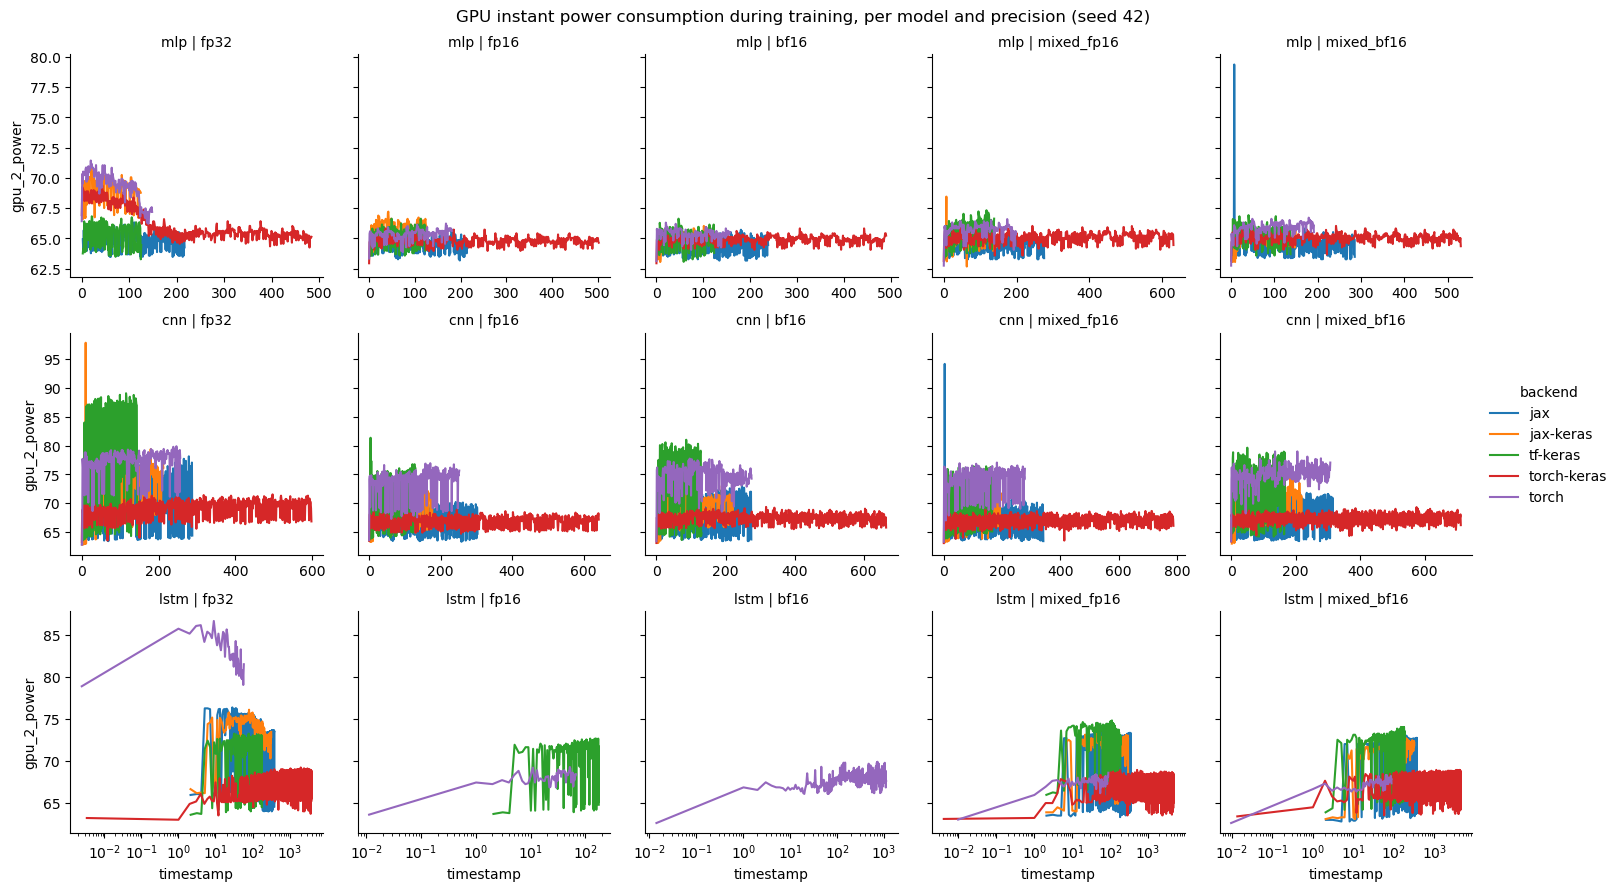

In [43]:
plot = sns.relplot(
    data=energy_df.query("seed == '42'"),
    x="timestamp",
    y="gpu_2_power",
    kind="line",
    hue="backend",
    col="precision",
    row="model_type",
    facet_kws={"sharey": "row", "sharex": False},
    hue_order=backend_order,
    col_order=precision_order,
    row_order=model_order,
    height=3
)

add_title(plot, "GPU instant power consumption during training, per model and precision (seed 42)", adjust=0.93)

plot.set_titles(row_template="{row_name}", col_template="{col_name}")

for ax in plot.axes[-1]:
    ax.set_xscale("log")

### GPU Energy Consumption

In [44]:
# Energy (J) = Power (W) * time (s)
energy_df["dt"] = energy_df.groupby(experiment_config)["timestamp"].diff().fillna(0)

energy_df["energy_j"] = energy_df["gpu_2_power"] * energy_df["dt"]
energy_df["energy_kwh"] = energy_df["energy_j"] / (1000 * 3600)
energy_df["cum_energy_kwh"] = energy_df.groupby(experiment_config)["energy_kwh"].cumsum()

energy_df.head()

,backend,model_type,precision,seed,timestamp,gpu_2_power,dt,energy_j,energy_kwh,cum_energy_kwh
0,jax,mlp,fp32,42,2.190392,64.923,0.000000,0.000000,0.000000,0.000000
1,jax,mlp,fp32,42,3.191456,63.950,1.001064,64.018032,0.000018,0.000018
2,jax,mlp,fp32,42,4.192263,65.681,1.000807,65.734008,0.000018,0.000036
3,jax,mlp,fp32,42,5.193223,64.644,1.000959,64.706019,0.000018,0.000054
4,jax,mlp,fp32,42,6.194193,64.436,1.000970,64.498511,0.000018,0.000072


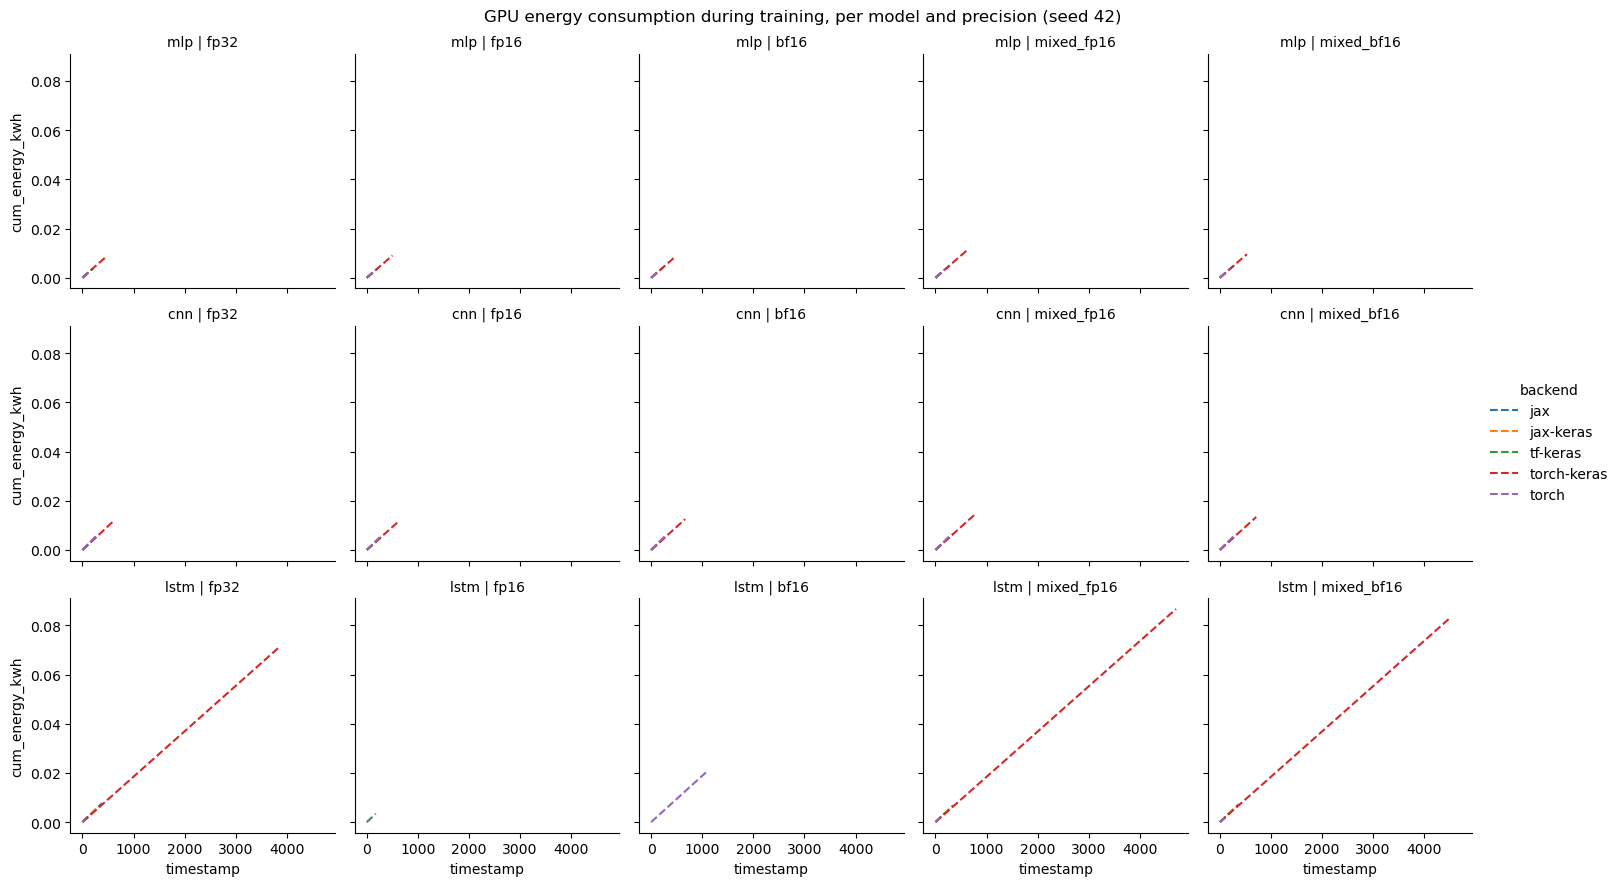

In [45]:
plot = sns.relplot(
    data=energy_df.query("seed == '42'"),
    x="timestamp",
    y="cum_energy_kwh",
    kind="line",
    hue="backend",
    col="precision",
    row="model_type",
    facet_kws={"sharey": True, "sharex": True},
    height=3,
    linestyle="--",
    alpha=1
)

add_title(plot, "GPU energy consumption during training, per model and precision (seed 42)", adjust=0.93)

plot.set_titles(row_template="{row_name}", col_template="{col_name}")


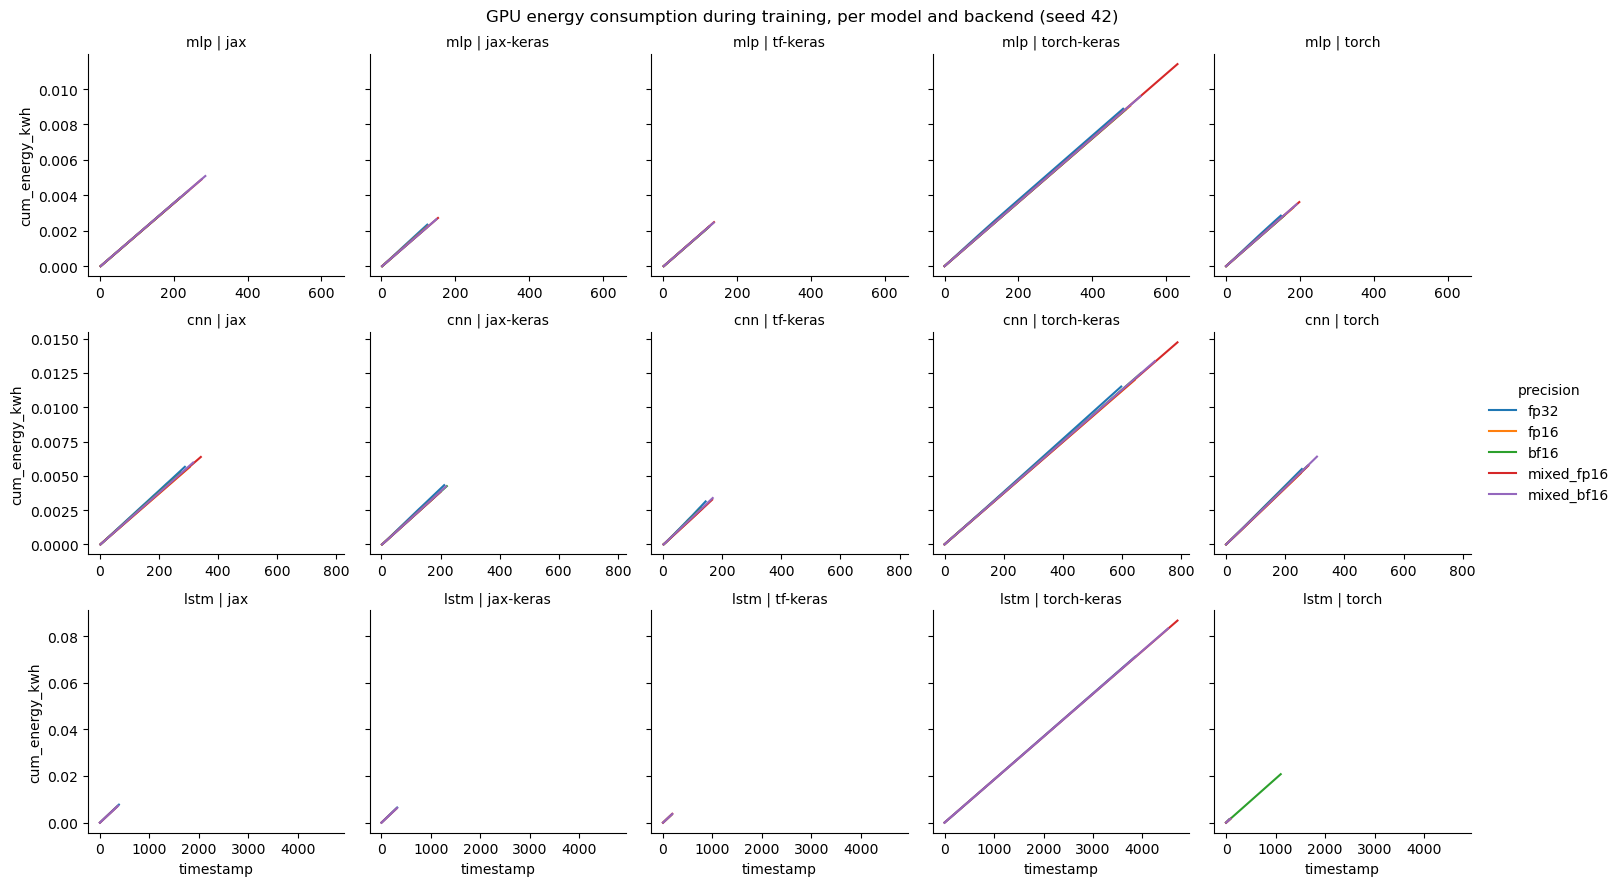

In [46]:
plot = sns.relplot(
    data=energy_df.query("seed == '42'"),
    x="timestamp",
    y="cum_energy_kwh",
    kind="line",
    hue="precision",
    col="backend",
    row="model_type",
    facet_kws={"sharey": "row", "sharex": "row"},
    height=3
)

add_title(plot, "GPU energy consumption during training, per model and backend (seed 42)", adjust=0.93)

plot.set_titles(row_template="{row_name}", col_template="{col_name}")


In [47]:

total_energy_df = (
    energy_df
    .groupby(experiment_config)["energy_j"]
    .sum()
    .reset_index()
    .rename(columns={"energy_j": "energy"})
)

total_energy_df["energy"] = total_energy_df["energy"] / 1000 # kJ

total_energy_df.head()

,backend,model_type,precision,seed,energy
0,jax,mlp,fp32,42,13.898514
1,jax,mlp,fp32,43,15.192393
2,jax,mlp,fp32,44,14.993291
3,jax,mlp,fp16,42,13.783159
4,jax,mlp,fp16,43,14.588840


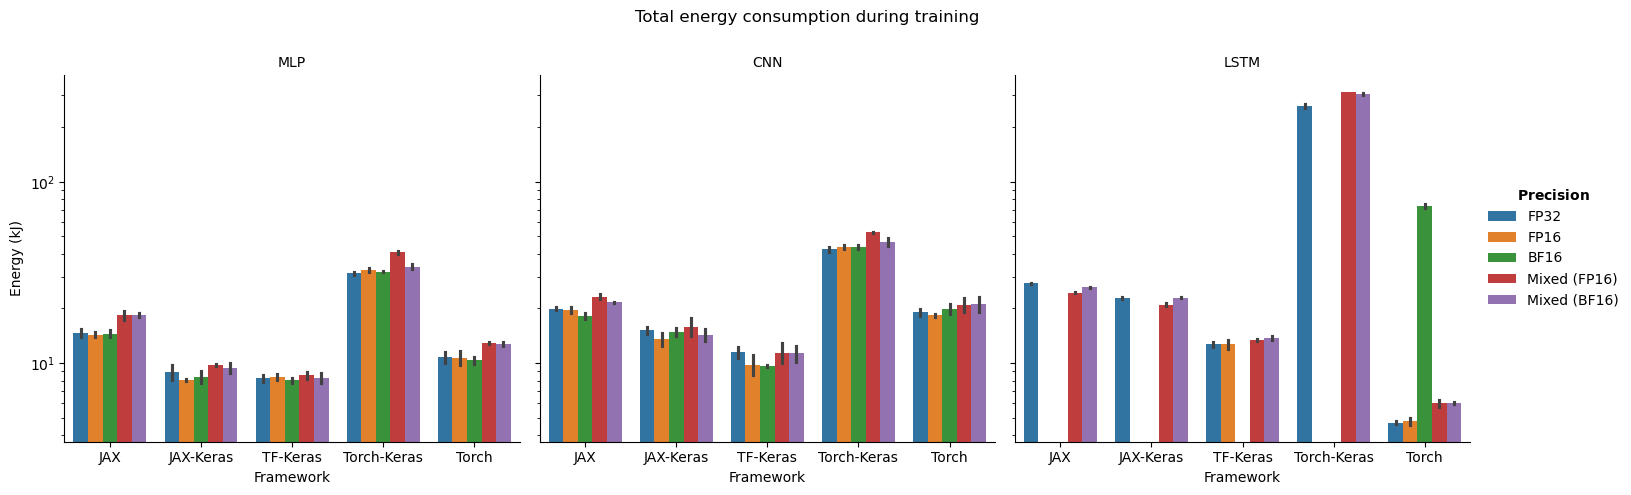

In [48]:
plot = sns.catplot(
    data=add_labels(total_energy_df),
    x="backend",
    y="energy",
    hue="precision",
    col="model_type",
    kind="bar",
    errorbar="sd"
)

add_title(plot, "Total energy consumption during training")
format_legend_title(plot)

plot.set_titles(col_template="{col_name}")
plot.set_axis_labels(titles["backend"], "Energy (kJ)")

plot.set(yscale="log")

save_svg(plot, "total_energy_bars")

In [49]:
base_df = total_energy_df.query("model_type=='lstm' and backend=='torch'").copy()
base_df = (
    base_df.groupby(experiment_config[:-1])["energy"]
    .median()
    .reset_index()
)
ref = base_df["energy"].min()
base_df["energy_comp"] = (base_df["energy"] / ref)
base_df = base_df.sort_values(by="energy", ascending=True)
base_df.head()

,backend,model_type,precision,energy,energy_comp
70,torch,lstm,fp32,4.651266,1.000000
71,torch,lstm,fp16,4.726964,1.016275
74,torch,lstm,mixed_bf16,6.045282,1.299707
73,torch,lstm,mixed_fp16,6.084652,1.308171
72,torch,lstm,bf16,73.592108,15.821952


In [50]:
base_df = total_energy_df.copy()
base_df["mixed"] = base_df["precision"].str.contains("mixed")
base_df = base_df[base_df["energy"] > 0]
base_df = (
    base_df.groupby(experiment_config[:-2] + ["mixed"])["energy"]
    .median()
    .reset_index()
)
base_df = base_df.pivot_table(
    index=experiment_config[:-2], 
    columns="mixed", 
    values="energy"
).reset_index()

base_df = base_df.rename(columns={False: "energy_no_mixed", True: "energy_mixed"})
base_df["comp"] = base_df["energy_mixed"] / base_df["energy_no_mixed"]

print(f"Result: {(base_df['comp'].median() - 1) * 100}")

Result: 16.226879263333572


### GPU Energy per Hour

In [51]:
time_df = exp_config_category(time_df)
time_df.head()

,backend,model_type,model_complexity,precision,seed,training_time,testing_time
0,jax,cnn,simple,bf16,42,276.151817,2.418015
1,jax,cnn,simple,bf16,43,258.165341,2.439186
2,jax,cnn,simple,bf16,44,272.022249,2.433130
3,jax,cnn,simple,fp16,42,305.029659,2.429303
4,jax,cnn,simple,fp16,43,283.138871,2.441872


In [52]:
total_energy_df = pd.merge(
    total_energy_df,
    time_df[experiment_config + ["training_time"]],
    on=experiment_config,
    how="left"
)

total_energy_df["energy_per_hour"] = total_energy_df["energy"] / (total_energy_df["training_time"] / 3600)

total_energy_df.head()

,backend,model_type,precision,seed,energy,training_time,energy_per_hour
0,jax,mlp,fp32,42,13.898514,218.031574,229.483503
1,jax,mlp,fp32,43,15.192393,234.050772,233.678420
2,jax,mlp,fp32,44,14.993291,229.041067,235.660130
3,jax,mlp,fp16,42,13.783159,217.017115,228.642664
4,jax,mlp,fp16,43,14.588840,231.114597,227.245804


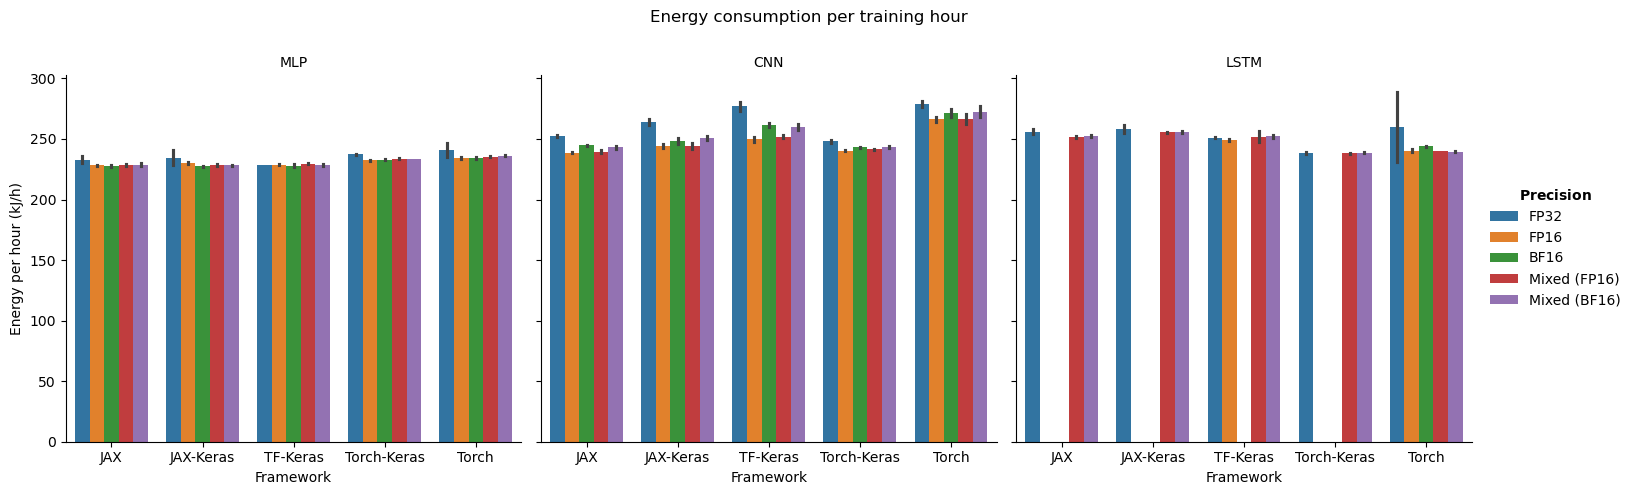

In [53]:
plot = sns.catplot(
    data=add_labels(total_energy_df),
    x="backend",
    y="energy_per_hour",
    hue="precision",
    col="model_type",
    kind="bar",
    errorbar="sd"
)

add_title(plot, "Energy consumption per training hour")
format_legend_title(plot)
plot.set_axis_labels(titles["backend"], "Energy per hour (kJ/h)")

plot.set_titles(col_template="{col_name}")

save_svg(plot, "energy_per_hour_bars")

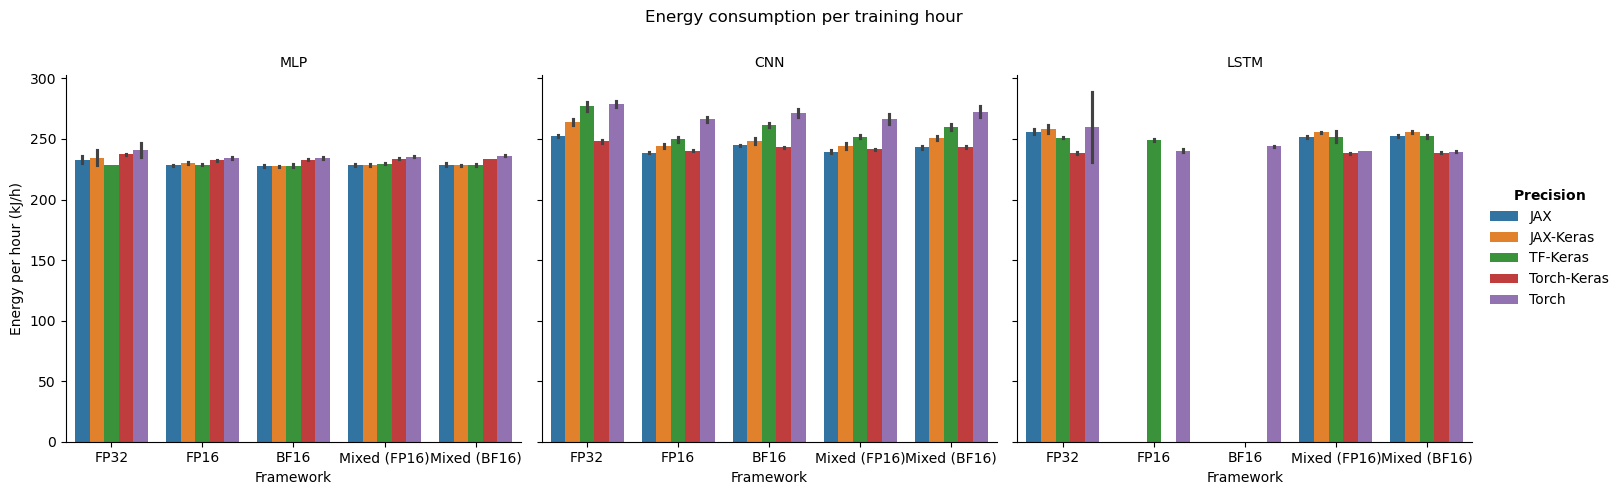

In [54]:
plot = sns.catplot(
    data=add_labels(total_energy_df),
    x="precision",
    y="energy_per_hour",
    hue="backend",
    col="model_type",
    kind="bar",
    errorbar="sd"
)

add_title(plot, "Energy consumption per training hour")
format_legend_title(plot)
plot.set_axis_labels(titles["backend"], "Energy per hour (kJ/h)")

plot.set_titles(col_template="{col_name}")

In [55]:
total_energy_df.groupby(["backend", "model_type", ])["energy_per_hour"].mean().reset_index().query("model_type == 'lstm'")

,backend,model_type,energy_per_hour
2,jax,lstm,253.426843
5,jax-keras,lstm,256.276421
8,tf-keras,lstm,250.999140
11,torch-keras,lstm,238.455310
14,torch,lstm,244.721314


In [56]:
energy_sum_df = (
    total_energy_df
    .groupby(["backend"])
    .agg(
        total_energy=("energy", "sum"),
        total_time=("training_time", "sum")
    )
    .reset_index()
)

energy_sum_df["global_energy_per_hour"] = energy_sum_df["total_energy"] / (energy_sum_df["total_time"] / 3600)
energy_sum_df = energy_sum_df.sort_values(by="global_energy_per_hour", ascending=False)

max_value = energy_sum_df["global_energy_per_hour"].max()
energy_sum_df["improvement"] = 1 - energy_sum_df["global_energy_per_hour"] / max_value

energy_sum_df.head()

,backend,total_energy,total_time,global_energy_per_hour,improvement
4,torch,754.321935,10782.066215,251.858866,0.000000
2,tf-keras,442.112094,6436.453620,247.279579,0.018182
1,jax-keras,555.341053,8096.903640,246.912632,0.019639
0,jax,783.187923,11668.712486,241.627046,0.040625
3,torch-keras,3839.491511,57916.238338,238.657928,0.052414


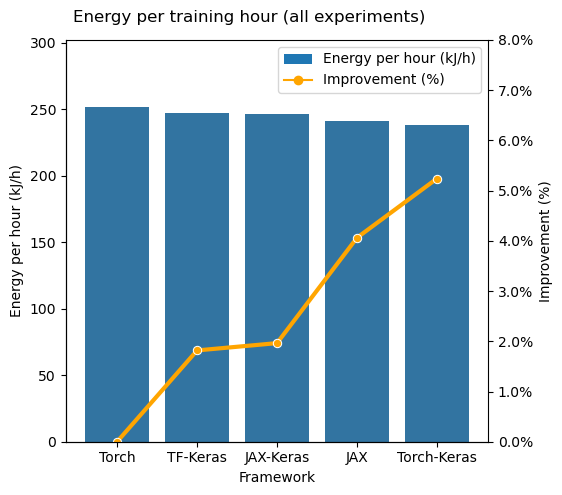

In [57]:
base_df = add_labels(energy_sum_df)

plot = sns.catplot(
    data=base_df,
    x="backend",
    y="global_energy_per_hour",
    kind="bar",
    errorbar="sd",
    order=base_df["backend"]
)

ax = plot.ax
ax.set_ylabel("Energy per hour (kJ/h)")
ax.set_ylim(0, max_value * 1.2)

ax2 = ax.twinx()
ax2.yaxis.set_major_formatter(PercentFormatter(1))
ax2.set_ylabel("Improvement (%)")
ax2.set_ylim(0, 0.08)

sns.lineplot(
    data=base_df,
    x="backend",
    y="improvement",
    ax=ax2,
    marker="o",
    color="orange",
    linewidth=3
)

add_title(plot, "Energy per training hour (all experiments)", adjust=0.92)
plot.set_titles(col_template="{col_name}")
plot.set_axis_labels(titles["backend"], "Energy per hour (kJ/h)")


legend_elements = [
    Patch(label="Energy per hour (kJ/h)"),
    Line2D([0], [0], color="orange", marker="o", label="Improvement (%)"),
]

ax.legend(handles=legend_elements, loc="best")

save_svg(plot, "energy_per_hour_all")


## Test results

In [58]:
df_list = []

for keys, subset_df in index_df[index_df["filename"] == "test"].groupby(experiment_config):
    backend, model_type, precision, seed = keys

    base_df = pd.read_csv(subset_df.iloc[0]["path"])

    base_df["backend"] = backend
    base_df["model_type"] = model_type
    base_df["precision"] = precision
    base_df["seed"] = seed

    df_list.append(base_df)

test_df = pd.concat(df_list, ignore_index=True)
test_df = exp_config_category(test_df)

test_df = test_df[experiment_config + ["time", "loss", "metric"]]
test_df = test_df.sort_values(by=experiment_config).reset_index(drop=True)

test_df.head()

,backend,model_type,precision,seed,time,loss,metric
0,jax,mlp,fp32,42,2.446716,0.282897,0.898985
1,jax,mlp,fp32,43,2.461142,0.284469,0.900876
2,jax,mlp,fp32,44,2.439721,0.287033,0.895999
3,jax,mlp,fp16,42,3.424967,NaN,0.100717
4,jax,mlp,fp16,43,3.440528,NaN,0.100717


In [59]:
failed_df: pd.DataFrame = (
    test_df.groupby(experiment_config)
    .apply(lambda g: g[["loss", "metric"]].isna().values.any())
    .reset_index(name="failed")
)

# Add experiments with errors
error_df["error"] = True

failed_df = failed_df.merge(
    error_df[experiment_config + ["error"]],
    on=experiment_config,
    how="outer"
)

failed_df["failed"] = failed_df["failed"].fillna(False)
failed_df["error"] = failed_df["error"].fillna(False)

failed_df.head()

/tmp/ipykernel_1500645/3708063559.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df.groupby(experiment_config)


,backend,model_type,precision,seed,failed,error
0,jax,cnn,bf16,42,False,False
1,jax,cnn,bf16,43,False,False
2,jax,cnn,bf16,44,False,False
3,jax,cnn,fp16,42,True,False
4,jax,cnn,fp16,43,True,False


In [60]:
num_failed_df = (
    failed_df.groupby(["precision", "seed"])
    .apply(lambda g: pd.Series({
        "num_success": (~g["failed"] & ~g["error"]).sum(),
        "num_failed": g["failed"].sum(),
        "num_error": g["error"].sum()
    }))
    .reset_index()
)

num_failed_df["precision"] = pd.Categorical(
    num_failed_df["precision"],
    categories=precision_order,
    ordered=True
)
num_failed_df = num_failed_df.sort_values(by="precision")

num_failed_df.head()

/tmp/ipykernel_1500645/237086042.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  failed_df.groupby(["precision", "seed"])


,precision,seed,num_success,num_failed,num_error
6,fp32,42,15,0,0
7,fp32,43,15,0,0
8,fp32,44,15,0,0
3,fp16,42,3,9,3
4,fp16,43,3,9,3


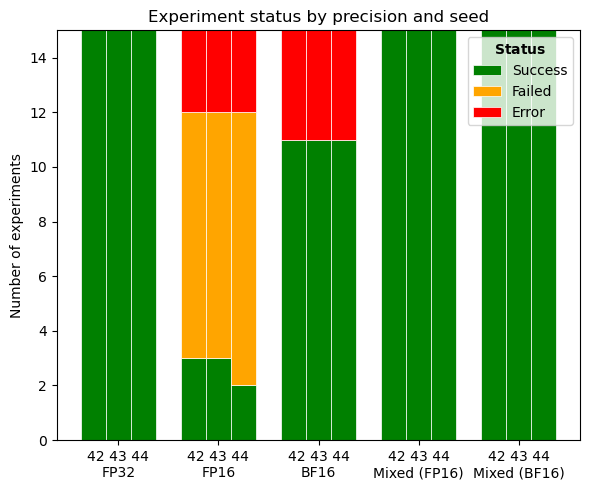

In [61]:
colors = {
    "num_success": "green",
    "num_failed":  "orange",
    "num_error":   "red"
}

x = np.arange(len(orders["precision"])) # base positions
bar_width = 0.25

fig, ax = plt.subplots(figsize=(6,5))

for i, seed in enumerate(orders["seed"]):
    subset = num_failed_df[num_failed_df["seed"] == seed]
    bottoms = np.zeros(len(subset))

    for col in colors.keys():
        ax.bar(
            x + i * bar_width, # Move each seed bars
            subset[col].values,
            bar_width,
            bottom=bottoms,
            color=colors[col],
            linewidth=0.5,
            edgecolor="white"
        )
        bottoms += subset[col].values


ax.set_xticks(x + bar_width)
precision_labels = labels["precision"]
ax.set_xticklabels([f"42 43 44\n{precision_labels[precision]}" for precision in orders["precision"]])

ax.set_ylabel("Number of experiments")

ax.set_title("Experiment status by precision and seed")
ax.legend(["Success","Failed","Error"], title=r"$\bf{Status}$", loc="upper right")

plt.tight_layout()
plt.show()

save_svg(fig, "status")

In [62]:
num_failed_df[["num_success", "num_failed", "num_error"]].sum()

num_success    176
num_failed      28
num_error       21
dtype: int64

In [63]:
test_metric_df = test_df.melt(
    id_vars=experiment_config,
    value_vars=["loss", "metric"],
    var_name="measure",
    value_name="value"
)
test_metric_df.head()

,backend,model_type,precision,seed,measure,value
0,jax,mlp,fp32,42,loss,0.282897
1,jax,mlp,fp32,43,loss,0.284469
2,jax,mlp,fp32,44,loss,0.287033
3,jax,mlp,fp16,42,loss,NaN
4,jax,mlp,fp16,43,loss,NaN


In [64]:
def plot_test_results(model_type: str, loss_name: str, metric_name: str, log=False):
    df = add_labels(test_df[test_df["model_type"] == model_type])

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    sns.barplot(
        data=df,
        x="backend",
        y="loss",
        hue="precision",
        ax=axes[0]
    )

    axes[0].set_title(f"Loss ({loss_name})")
    axes[0].set_xlabel("Framework")
    axes[0].set_ylabel("Loss")
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
    axes[0].legend_.remove()


    sns.barplot(
        data=df,
        x="backend",
        y="metric",
        hue="precision",
        ax=axes[1]
    )

    axes[1].set_title(f"{metric_name}")
    axes[1].set_xlabel("Framework")
    axes[1].set_ylabel(f"{metric_name}")
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")
    axes[1].legend_.remove()

    # Legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 1),
        ncol=len(labels)
    )

    fig.suptitle(f"Test results ({model_type.upper()})", y=1.05)

    if log:
        for _, ax in enumerate(axes.flat):
            ax.set(yscale="log")
            ax.set_ylabel(ax.get_ylabel() + " (log)")

    plt.tight_layout()
    save_svg(fig, f"test_res_{model_type}")

    plt.show()

/tmp/ipykernel_1500645/3057154217.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_1500645/3057154217.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


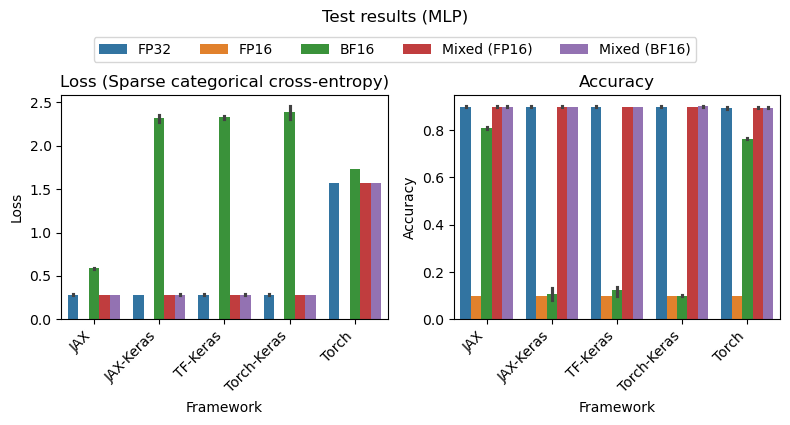

In [65]:
plot_test_results("mlp", "Sparse categorical cross-entropy", "Accuracy")

In [66]:
base_df = test_df.query("model_type=='mlp'").copy()
base_df = (
    base_df.groupby(experiment_config[:-2])["loss"]
    .median()
    .reset_index()
)
ref = base_df["loss"].min()
base_df["comp"] = (base_df["loss"] / ref)
base_df = base_df.sort_values(by="loss", ascending=True)
base_df.head()

,backend,model_type,loss,comp
3,jax-keras,mlp,0.283961,1.000000
6,tf-keras,mlp,0.284331,1.001304
9,torch-keras,mlp,0.284654,1.002440
0,jax,mlp,0.284691,1.002570
12,torch,mlp,1.567934,5.521653


/tmp/ipykernel_1500645/3057154217.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_1500645/3057154217.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


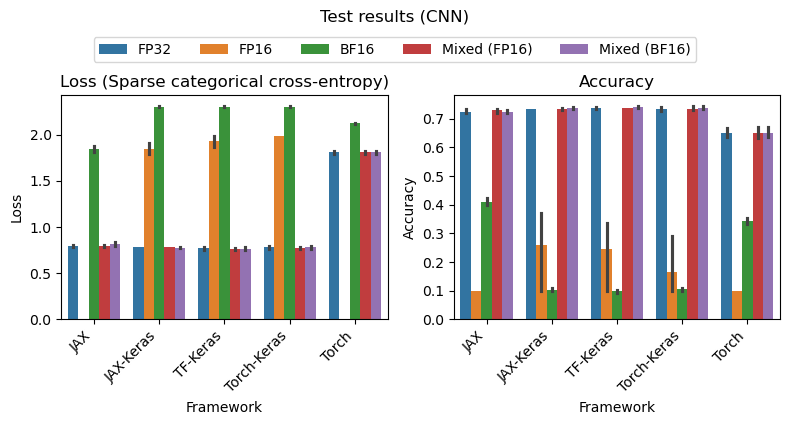

In [67]:
plot_test_results("cnn", "Sparse categorical cross-entropy", "Accuracy")

In [68]:
base_df = test_df.query("model_type=='cnn'").copy()
base_df = (
    base_df.groupby(experiment_config[:-2])["metric"]
    .median()
    .reset_index()
)
ref = base_df["metric"].max()
base_df["comp"] = (base_df["metric"] / ref) - 1
base_df = base_df.sort_values(by="metric", ascending=True)
base_df.head()

,backend,model_type,metric,comp
13,torch,cnn,0.634654,-0.137464
1,jax,cnn,0.720143,-0.021278
10,torch-keras,cnn,0.730100,-0.007747
4,jax-keras,cnn,0.732100,-0.005029
7,tf-keras,cnn,0.735800,0.000000


/tmp/ipykernel_1500645/3057154217.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_1500645/3057154217.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


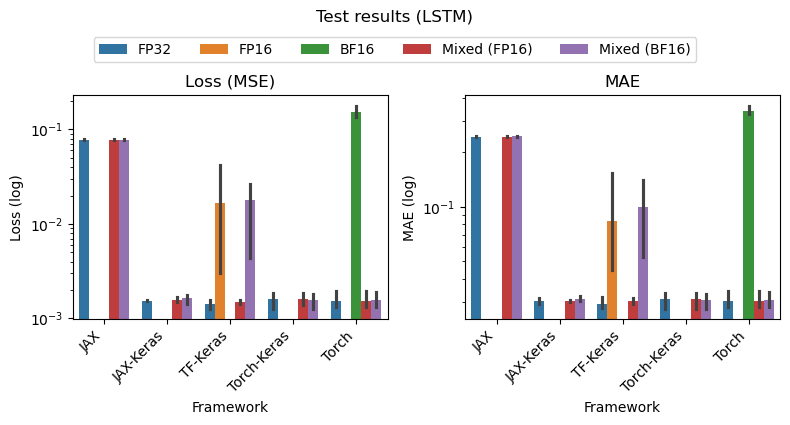

In [69]:
plot_test_results("lstm", "MSE", "MAE", log=True)

In [70]:
base_df = test_df.query("model_type=='lstm'").copy()
base_df = (
    base_df.groupby(experiment_config[:-2])["loss"]
    .median()
    .reset_index()
)
ref = base_df["loss"].min()
base_df["comp"] = (base_df["loss"] / ref)
base_df = base_df.sort_values(by="loss", ascending=True)
base_df.head()

,backend,model_type,loss,comp
5,jax-keras,lstm,0.001552,1.000000
14,torch,lstm,0.001677,1.080637
11,torch-keras,lstm,0.001713,1.104190
8,tf-keras,lstm,0.002377,1.531724
2,jax,lstm,0.077860,50.181020


## Mixed metrics graphs

### Correlation

In [71]:
total_energy_df.head()

,backend,model_type,precision,seed,energy,training_time,energy_per_hour
0,jax,mlp,fp32,42,13.898514,218.031574,229.483503
1,jax,mlp,fp32,43,15.192393,234.050772,233.678420
2,jax,mlp,fp32,44,14.993291,229.041067,235.660130
3,jax,mlp,fp16,42,13.783159,217.017115,228.642664
4,jax,mlp,fp16,43,14.588840,231.114597,227.245804


In [72]:
# Remove error experiments
base_df = total_energy_df[~total_energy_df["training_time"].isna()].copy()
base_df = base_df.sort_values(by=["model_type"])

results = []

for keys, group in base_df.groupby(["model_type"]):
    
    corr = group["training_time"].corr(group["energy"])

    X = group[["training_time"]].values
    y = group["energy"].values

    modelo = LinearRegression().fit(X, y)

    slope_w = modelo.coef_[0] * 1000 # kJ/s -> J/s = W
    intercept = modelo.intercept_
    r2 = modelo.score(X, y)

    results.append({
        "model_type": keys[0],
        "correlation": corr,
        "mean_power_W": slope_w,
        "intercept_kJ": intercept,
        "R2": r2
    })

results_df = pd.DataFrame(results)

results_df.round(5).head()

,model_type,correlation,mean_power_W,intercept_kJ,R2
0,mlp,0.99975,65.16200,-0.16384,0.99951
1,cnn,0.99803,65.83849,1.17495,0.99606
2,lstm,0.99998,66.04684,0.96295,0.99996


### Comparison plots

In [73]:
success_df = failed_df[~failed_df["failed"] & ~failed_df["error"]]
mask = (
    success_df.groupby(experiment_config[:-1])["seed"]
    .transform(lambda g: g.count() == 3)
)
success_df = success_df[mask][experiment_config].drop_duplicates()
success_df.head()

,backend,model_type,precision,seed
0,jax,cnn,bf16,42
1,jax,cnn,bf16,43
2,jax,cnn,bf16,44
6,jax,cnn,fp32,42
7,jax,cnn,fp32,43


In [74]:
# Add training_time and max_memory
mixed_df = time_df.merge(
    memory_df,
    on="backend",
    how="left"
)

# Add loss and metric
mixed_df = mixed_df.merge(
    test_df,
    on=experiment_config,
    how="left"
)

# Remove unsuccessful experiments
mixed_df = mixed_df.merge(
    success_df,
    on=experiment_config,
    how="inner"
)

mixed_df = (
    mixed_df.groupby(experiment_config[:-1])[["training_time", "max_memory", "loss", "metric"]]
    .mean()
    .reset_index()
)

mixed_df.head()

,backend,model_type,precision,training_time,max_memory,loss,metric
0,jax,cnn,bf16,268.779803,60.704285,1.848958,0.409468
1,jax,cnn,fp32,284.455284,60.704285,0.798786,0.724655
2,jax,cnn,mixed_bf16,319.503012,60.704285,0.816406,0.723195
3,jax,cnn,mixed_fp16,349.468161,60.704285,0.797201,0.728570
4,jax,lstm,fp32,387.828691,60.704285,0.078095,0.244797


In [75]:
# Remove experiments with bad results
mask = mixed_df.groupby("model_type")["loss"].transform("median")
filtered_df = mixed_df[mixed_df["loss"] <= mask]
len(filtered_df)

29

In [145]:
# No half precision experiment remains
filtered_df.query("precision==['fp16', 'bf16']").head()

,backend,model_type,precision,training_time,max_memory,loss,metric


In [168]:
markers = ["o", "X", "P", "^", "v"]
precision_markers = {precision_labels[precision]: marker for precision, marker in zip(orders["precision"], markers)}
precision_markers

{'FP32': 'o',
 'FP16': 'X',
 'BF16': 'P',
 'Mixed (FP16)': '^',
 'Mixed (BF16)': 'v'}

In [169]:
def make_legend(plot):
    
    backend_handles = []
    precision_handles = []

    colors = sns.color_palette(n_colors=5)
    for backend, color in zip(orders["backend"], colors):
        label = labels["backend"][backend]
        backend_handles.append(Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))

    for precision in orders["precision"]:
        if (precision in ["fp16", "bf16"]): # There are no experiments with these
            continue
        label = labels["precision"][precision]
        marker = precision_markers[label]
        precision_handles.append(Line2D([0], [0], marker=marker, color='black', linestyle='None', label=label, markersize=10))

    # Legend next to upper right plot
    first_ax = plot.axes.flat[1]

    # Backend legend
    title = titles["backend"]
    legend1 = first_ax.legend(handles=backend_handles, title=rf"$\bf{{ {title} }}$", loc='upper left', bbox_to_anchor=(1.05, 1))
    first_ax.add_artist(legend1)

    # Precision legend
    title = titles["precision"]
    legend2 = first_ax.legend(handles=precision_handles, title=rf"$\bf{{ {title} }}$", loc='upper left', bbox_to_anchor=(1.05, 0.6))

In [170]:
def get_pareto_df(df):
    df2 = df[['training_time', 'max_memory']].sort_values(['training_time', 'max_memory'])

    lowest_memory = np.inf
    points = []
    for _, row in df2.iterrows():
        if row['max_memory'] / lowest_memory < 0.99: # Minimum 1% improvement
            points.append((row['training_time'], row['max_memory']))
            lowest_memory = row['max_memory']

    pareto_df = pd.merge(
        df,
        pd.DataFrame(points, columns=['training_time','max_memory']),
        on=['training_time','max_memory']
    )

    return pareto_df

In [171]:
df = pd.DataFrame([(0,10,'a'),(1,3,'b'),(1,2,'c'),(2,5,'d'),(3,2,'e'),(4,1,'f')], columns=['training_time','max_memory','filler'])
df = get_pareto_df(df)
df.head()

,training_time,max_memory,filler
0,0,10,a
1,1,2,c
2,4,1,f


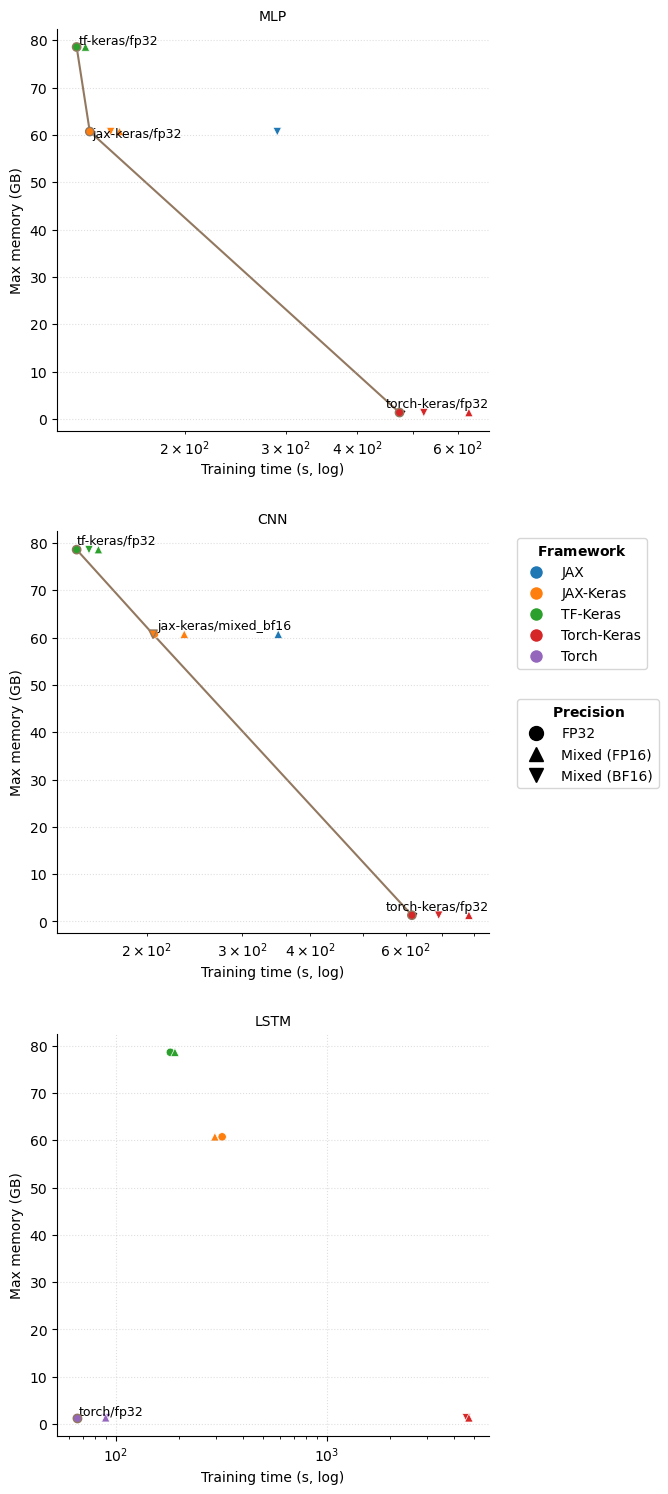

In [ ]:
plot = sns.relplot(
    data=add_labels(filtered_df),
    x="training_time",
    y="max_memory",
    hue="backend",
    style="precision",
    markers=precision_markers,
    row="model_type",
    facet_kws={"sharex": False, "sharey": False},
    legend=False
)

# Plot titles
plot.set_titles(row_template="{row_name}")

# Add space between rows (for labels)
plot.figure.subplots_adjust(wspace=0.2, hspace=0.25)

# Adjust labels per column
for axs in plot.axes:
    axs[0].set_ylabel("Max memory (GB)")

# log-x only for LSTM row
for model, axs in zip(model_order, plot.axes):
    if True:
        for ax in axs:
            ax.set(xscale="log")
            ax.set_xlabel("Training time (s, log)")
    else:
        for ax in axs:
            ax.set_xlabel("Training time (s)")


# Grid
for ax in plot.axes.flat:
    ax.grid(True, ls=":", alpha=.4)

make_legend(plot)

plot.add_legend()


# Quartiles and pareto
pareto_color = sns.color_palette("deep")[5]
add_medians = False

for model, ax in zip(orders["model_type"], plot.axes.flat):
    df = filtered_df.query("model_type == @model")
    
    # Medians
    if add_medians:
        x_med = df['training_time'].median()
        y_med = df['max_memory'].median()

        # Median lines
        ax.axvline(x_med, ls="--", lw=1, color="grey")
        ax.axhline(y_med, ls="--", lw=1, color="grey")
    
    
    # Pareto frontier
    pareto_df = get_pareto_df(df)

    sns.scatterplot(
        data=add_labels(pareto_df),
        x="training_time",
        y="max_memory",
        hue="backend",
        style="precision",
        markers=precision_markers,
        legend=False,
        ax=ax,
        
        edgecolor=pareto_color,
        linewidth=1,
        zorder=5
    )

    sns.lineplot(
        data=add_labels(pareto_df),
        x="training_time",
        y="max_memory",
        legend=False,
        ax=ax,
        
        color=pareto_color,
        zorder=-1
    )

    texts = []
    for _, row in pareto_df.iterrows():
        texts.append(
            ax.text(
                row.training_time,
                row.max_memory,
                f"{row.backend}/{row.precision}",
                fontsize=9
            )
        )
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="->", lw=1))
    
save_svg(plot, "comparison")

In [181]:
def make_legend(plot):
    
    backend_handles = []
    precision_handles = []

    colors = sns.color_palette(n_colors=5)
    for backend, color in zip(orders["backend"], colors):
        label = labels["backend"][backend]
        backend_handles.append(Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))

    for precision in orders["precision"]:
        if (precision in ["fp16", "bf16"]): # There are no experiments with these
            continue
        label = labels["precision"][precision]
        marker = precision_markers[label]
        precision_handles.append(Line2D([0], [0], marker=marker, color='black', linestyle='None', label=label, markersize=10))

    # Legend next to upper right plot
    first_ax = plot.axes.flat[0]

    # Backend legend
    title = titles["backend"]
    legend1 = first_ax.legend(handles=backend_handles, title=rf"$\bf{{ {title} }}$", loc='upper left', bbox_to_anchor=(1.05, 1))
    first_ax.add_artist(legend1)

    # Precision legend
    title = titles["precision"]
    legend2 = first_ax.legend(handles=precision_handles, title=rf"$\bf{{ {title} }}$", loc='upper left', bbox_to_anchor=(1.05, 0.6))

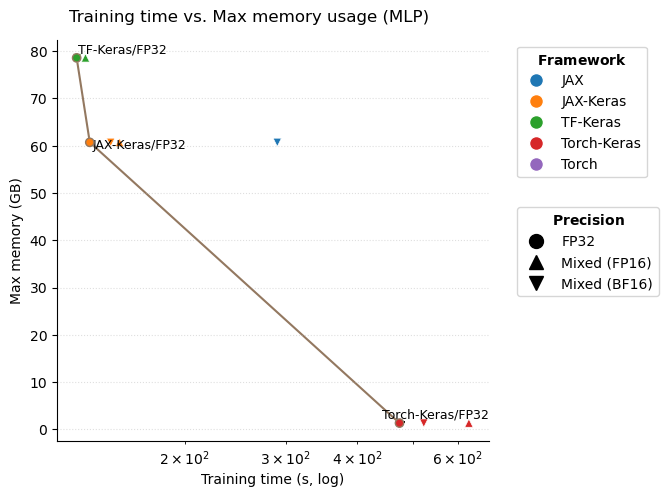

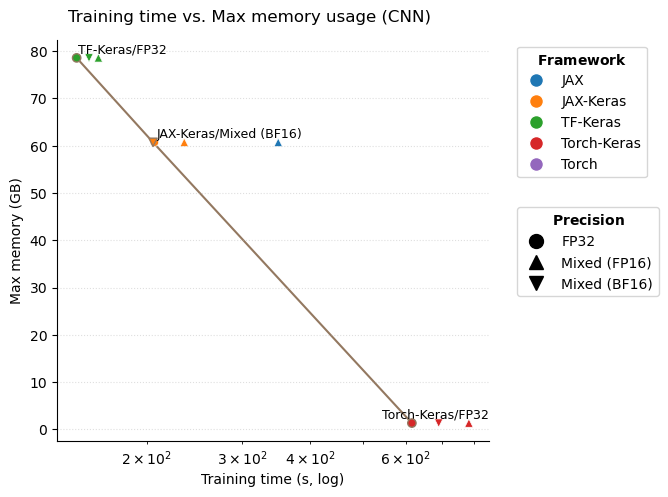

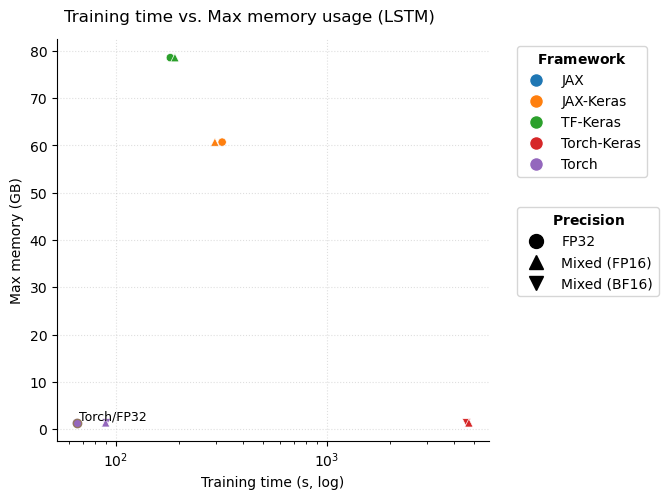

In [191]:
pareto_color = sns.color_palette("deep")[5]
add_medians = False

for model in orders["model_type"]:
    df = filtered_df.query("model_type == @model")

    plot = sns.relplot(
        data=add_labels(df),
        x="training_time",
        y="max_memory",
        hue="backend",
        style="precision",
        markers=precision_markers,
        facet_kws={"sharex": False, "sharey": False},
        legend=False
    )
    
    ax = plot.axes.flat[0]

    add_title(plot, f"Training time vs. Max memory usage ({model.upper()})", 0.92)

    # Add space between rows (for labels)
    plot.figure.subplots_adjust(wspace=0.2, hspace=0.25)

    # log-x only for LSTM row
    ax.set(xscale="log")

    plot.set_axis_labels("Training time (s, log)", "Max memory (GB)")

    # Grid
    ax.grid(True, ls=":", alpha=.4)

    make_legend(plot)

    plot.add_legend()

    # Medians
    if add_medians:
        x_med = df['training_time'].median()
        y_med = df['max_memory'].median()

        # Median lines
        ax.axvline(x_med, ls="--", lw=1, color="grey")
        ax.axhline(y_med, ls="--", lw=1, color="grey")
    
    
    # Pareto frontier
    pareto_df = get_pareto_df(df)
    pareto_df = add_labels(pareto_df)

    sns.scatterplot(
        data=pareto_df,
        x="training_time",
        y="max_memory",
        hue="backend",
        style="precision",
        markers=precision_markers,
        legend=False,
        ax=ax,
        
        edgecolor=pareto_color,
        linewidth=1,
        zorder=5
    )

    sns.lineplot(
        data=pareto_df,
        x="training_time",
        y="max_memory",
        legend=False,
        ax=ax,
        
        color=pareto_color,
        zorder=-1
    )

    texts = []
    for _, row in pareto_df.iterrows():
        texts.append(
            ax.text(
                row.training_time,
                row.max_memory,
                f"{row.backend}/{row.precision}",
                fontsize=9
            )
        )
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="->", lw=1))
    
    save_svg(plot, f"comparison_{model}")